# **Lymphoid subcluster**

Rewriting scanpy template for analysis on Sumner

In [ ]:
import sys
sys.path.append("../code")
from code.data_prep.io import *
from code.data_prep.processing import *
from code.plotting.plot_settings import *
from code.plotting.palettes import *

In [1]:
import scanpy as sc
from pathlib import Path
import numpy as np
import pandas as pd
import scrublet as scr

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
sc.settings.verbosity=3

In [3]:
main_dir = "/projects/robson-lab/research/endometriosis/"
sample_id = "Endometriosis-revision-3"
sub_dir = "TNK"

sc.settings.figdir = f"{main_dir}figures/{sample_id}"
matplotlib.rcParams["figure.facecolor"]="white"

In [4]:
from datetime import datetime
now = datetime.now()
timestamp = now.strftime("%Y%m%d")

def save_adata(adata, suffix="", subdir=""):
    filename = f"{adata.uns['sampleid']}{'-' + suffix if suffix else ''}-{timestamp}.h5ad"
    sc.write(Path(adata.uns["output_dir"]) / subdir / filename, adata)

In [5]:
sc.set_figure_params(dpi=150, color_map='Reds')
sns.set_style("white")

---

---

In [6]:
full = sc.read_h5ad(f"{main_dir}data/h5ad/{sample_id}/{sub_dir}/{sample_id}-TNK-20220103.h5ad")

In [7]:
full

AnnData object with n_obs × n_vars = 22282 × 21799
    obs: 'sequencing_saturation', 'Patient_id', 'stage', 'scrublet_predicted_doublet', 'scrublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mitochondrial', 'log1p_total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_hemoglobin', 'log1p_total_counts_hemoglobin', 'pct_counts_hemoglobin', 'library', '10x_chemistry', 'sample_name', 'sampleid', 'sample_type', 'leiden', 'leiden_R1', 'leiden_R2', 'leiden_R3', 'leiden_R4', 'leiden_R5', 'leiden_R6', 'leiden_R7', 'visible_doublet', 'cluster', 'cluster_R1', 'celltype', 'celltype_main'
    var: 'gene_ids', 'mitochondrial', 'hemoglobin', 'total_counts', 'n_cells_by_counts', 'ribosomal', 'cell_cycle', 'stress_response', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells'
    u

#### Batch Corrections & UMAP Computing

In [8]:
%load_ext rpy2.ipython

In [9]:
sc.pp.pca(full, svd_solver="arpack",use_highly_variable=True)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:01)


In [ ]:
pcs = full.obsm["X_pca"]
metadata = full.obs
covariates = ["Patient_id","stage"]
thetas = np.array([2,1])

In [ ]:
%%R -i pcs -i covariates -i thetas -i metadata -o pcs_harmony
library(harmony)
pcs_harmony <- HarmonyMatrix(
    pcs,
    metadata,
    vars_use=covariates,
    theta=thetas,
    do_pca=FALSE
)

In [13]:
harmonized = load_pcs(full, pcs_harmony)

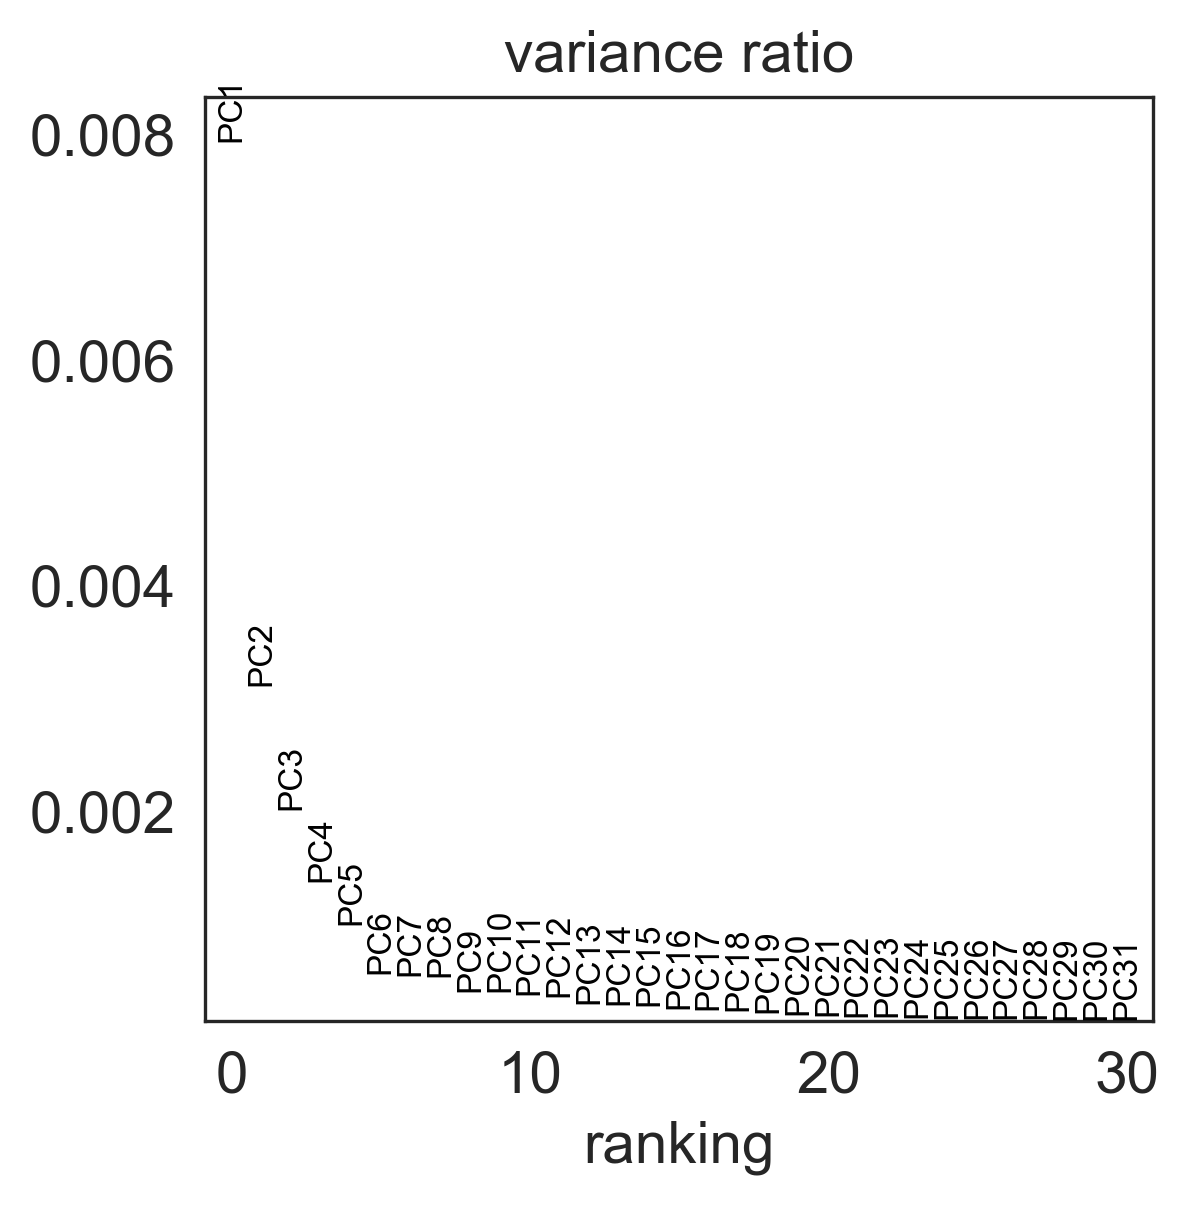

In [14]:
sc.pl.pca_variance_ratio(harmonized,show=False)

In [ ]:
sc.pp.neighbors(harmonized, n_neighbors=20, n_pcs=15, metric="correlation")
sc.tl.umap(harmonized, min_dist=0.05)

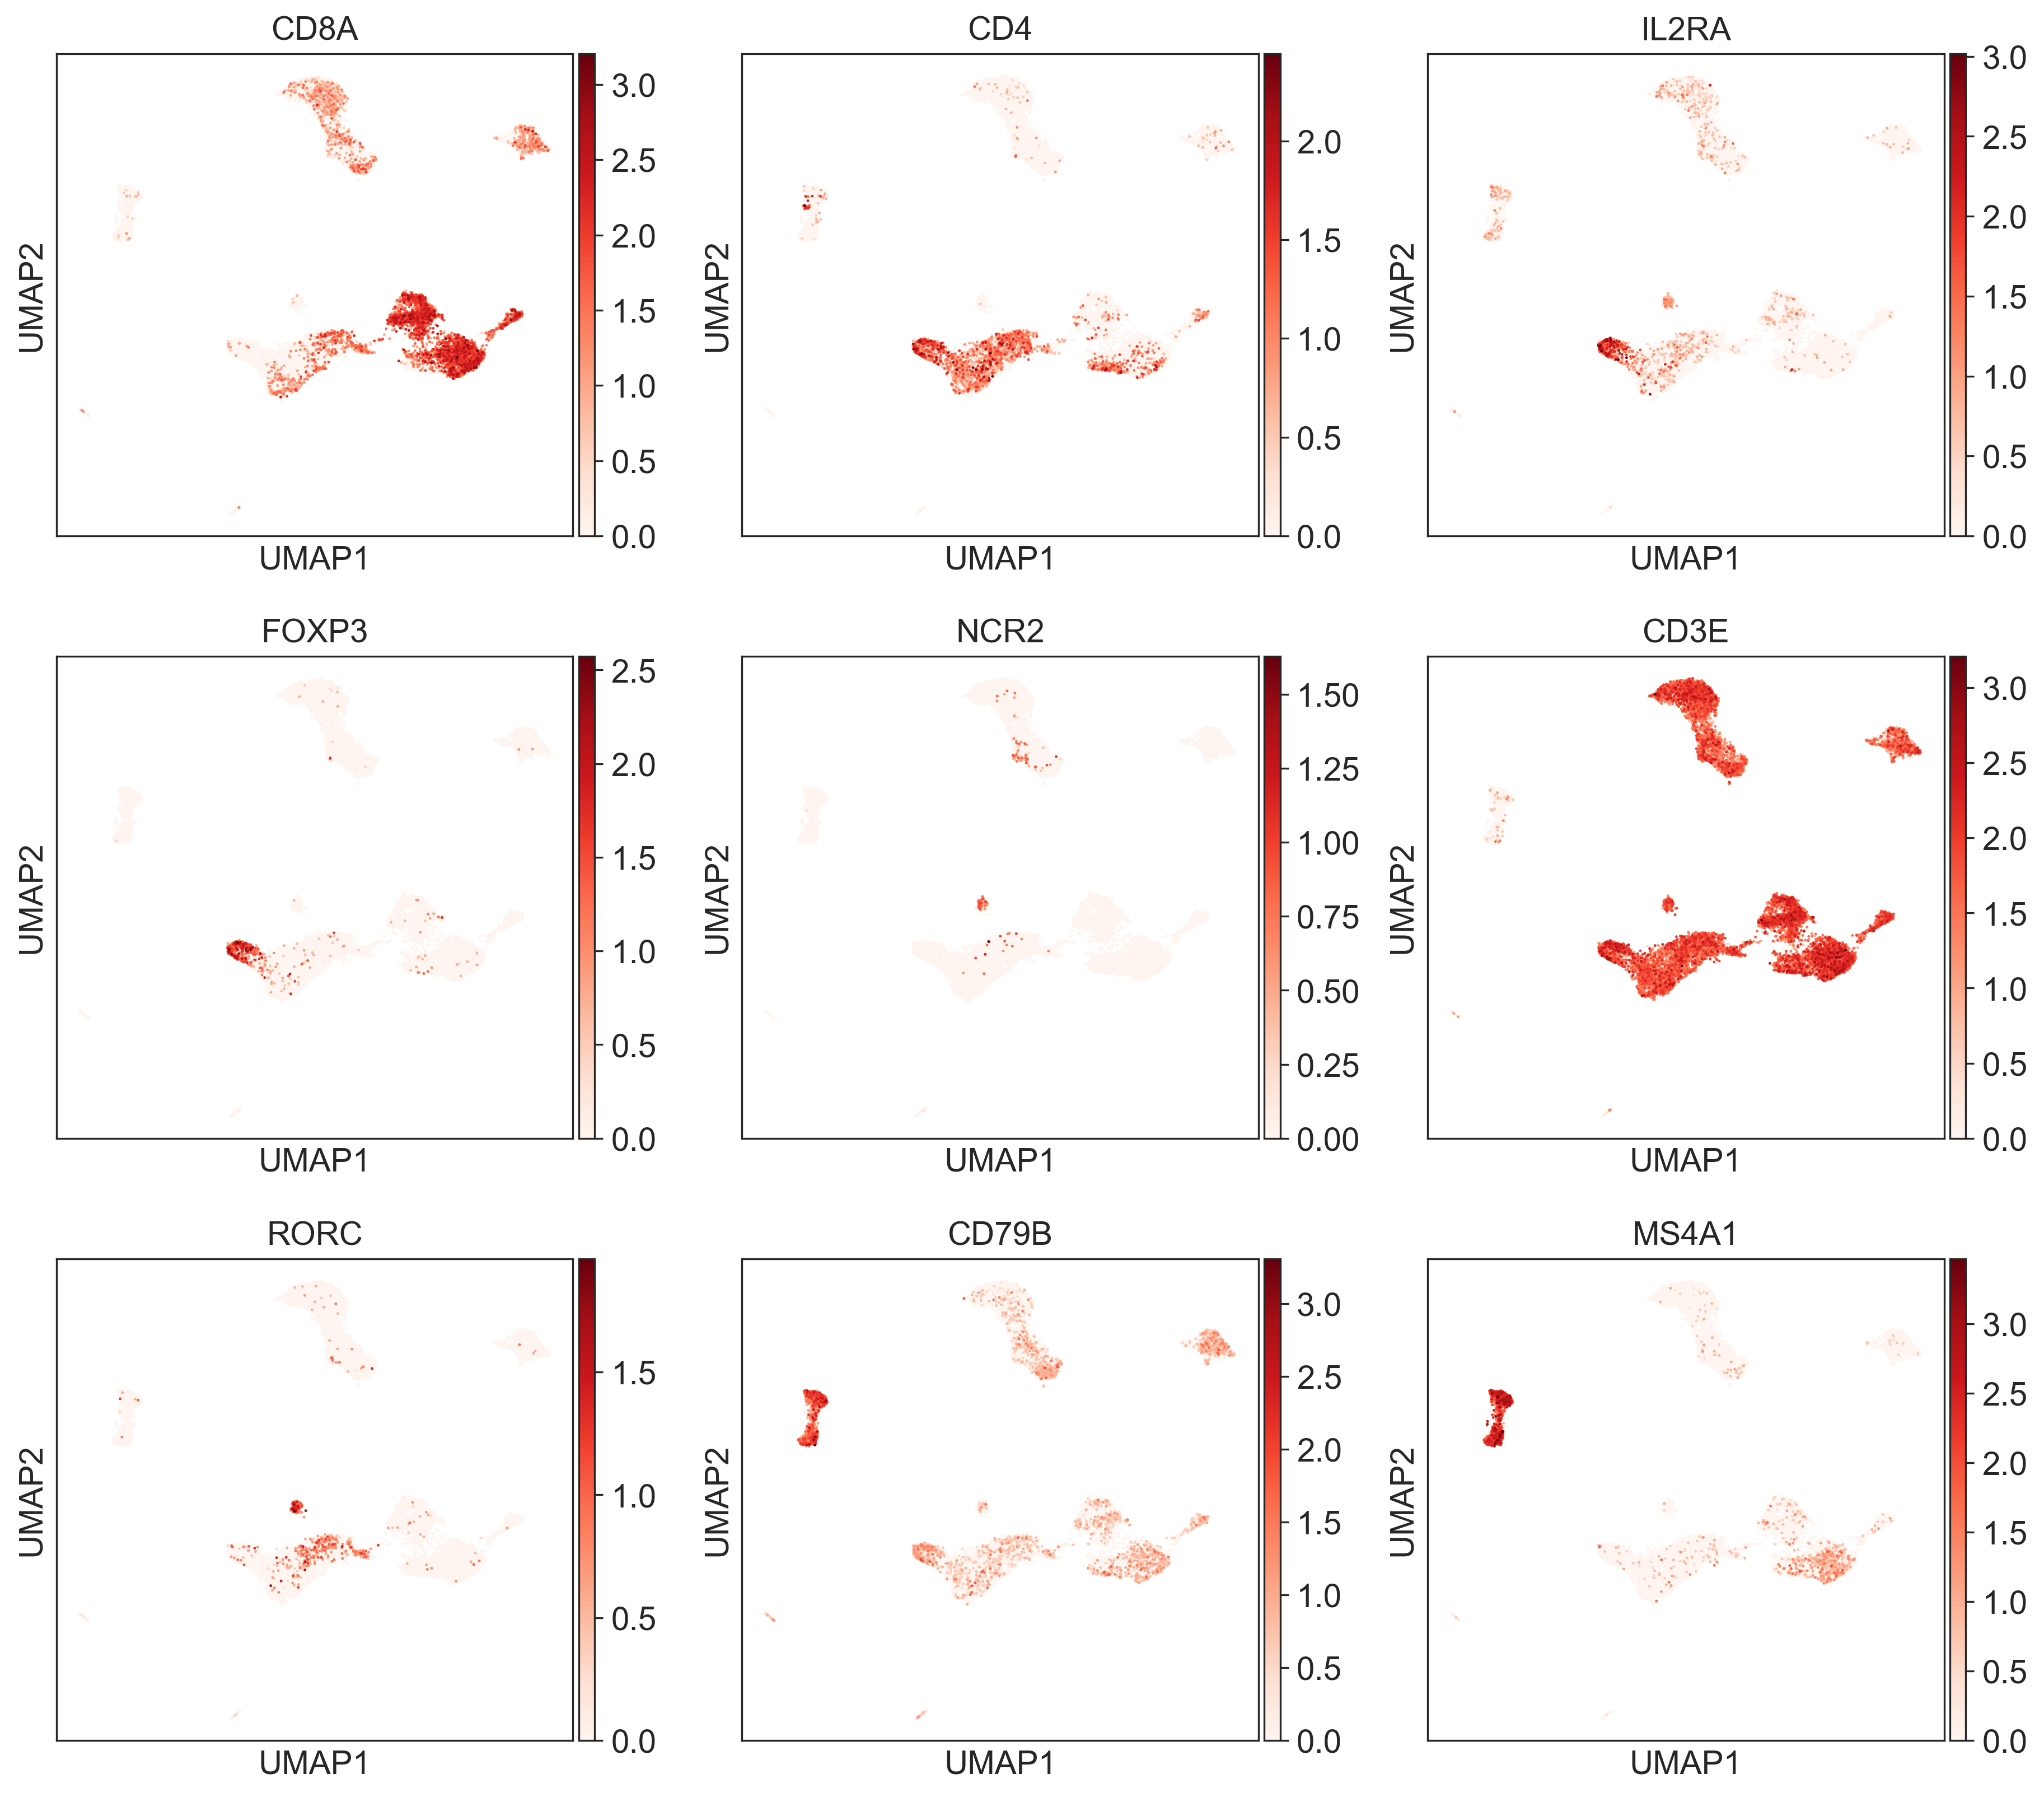

In [16]:
sc.pl.umap(harmonized, color=["CD8A","CD4","IL2RA","FOXP3","NCR2","CD3E","RORC","CD79B","MS4A1"],color_map="Reds",ncols=3)

---

#### Clustering

running Leiden clustering


/opt/conda/lib/python3.7/site-packages/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']


    finished: found 10 clusters and added
    'lym_leiden', the cluster labels (adata.obs, categorical) (0:00:06)


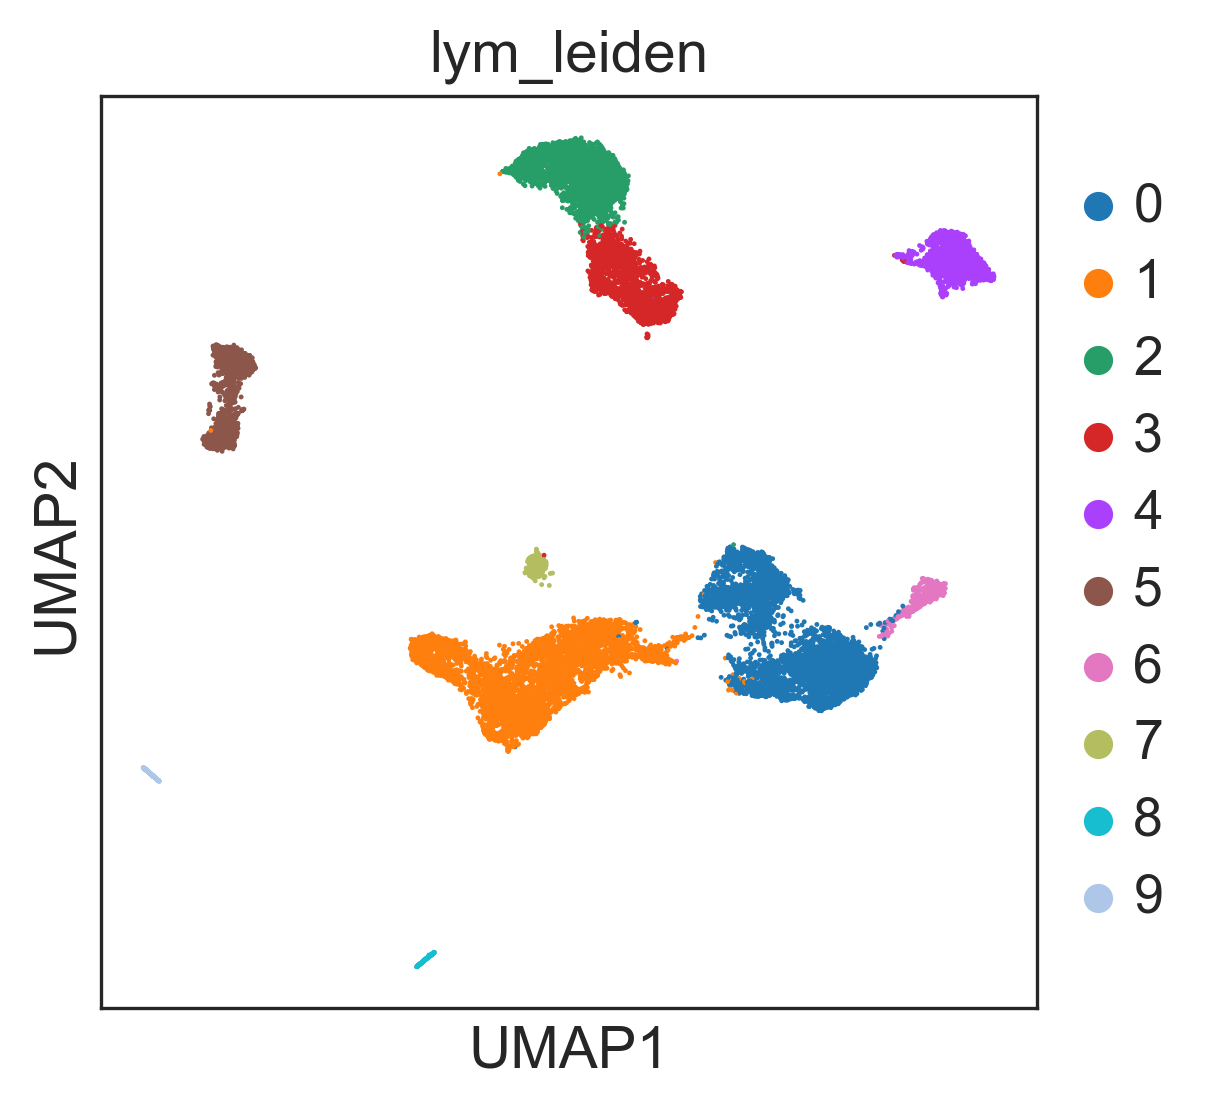

In [19]:
sc.tl.leiden(harmonized, resolution=0.2,key_added="lym_leiden")
sc.pl.umap(harmonized, 
           color=["lym_leiden"],
           use_raw=False,
          )

running Leiden clustering


/opt/conda/lib/python3.7/site-packages/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']


    finished: found 11 clusters and added
    'lym_leiden_R1', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering


/opt/conda/lib/python3.7/site-packages/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']


    finished: found 14 clusters and added
    'lym_leiden_R2', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering


/opt/conda/lib/python3.7/site-packages/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']


    finished: found 16 clusters and added
    'lym_leiden_R3', the cluster labels (adata.obs, categorical) (0:00:00)


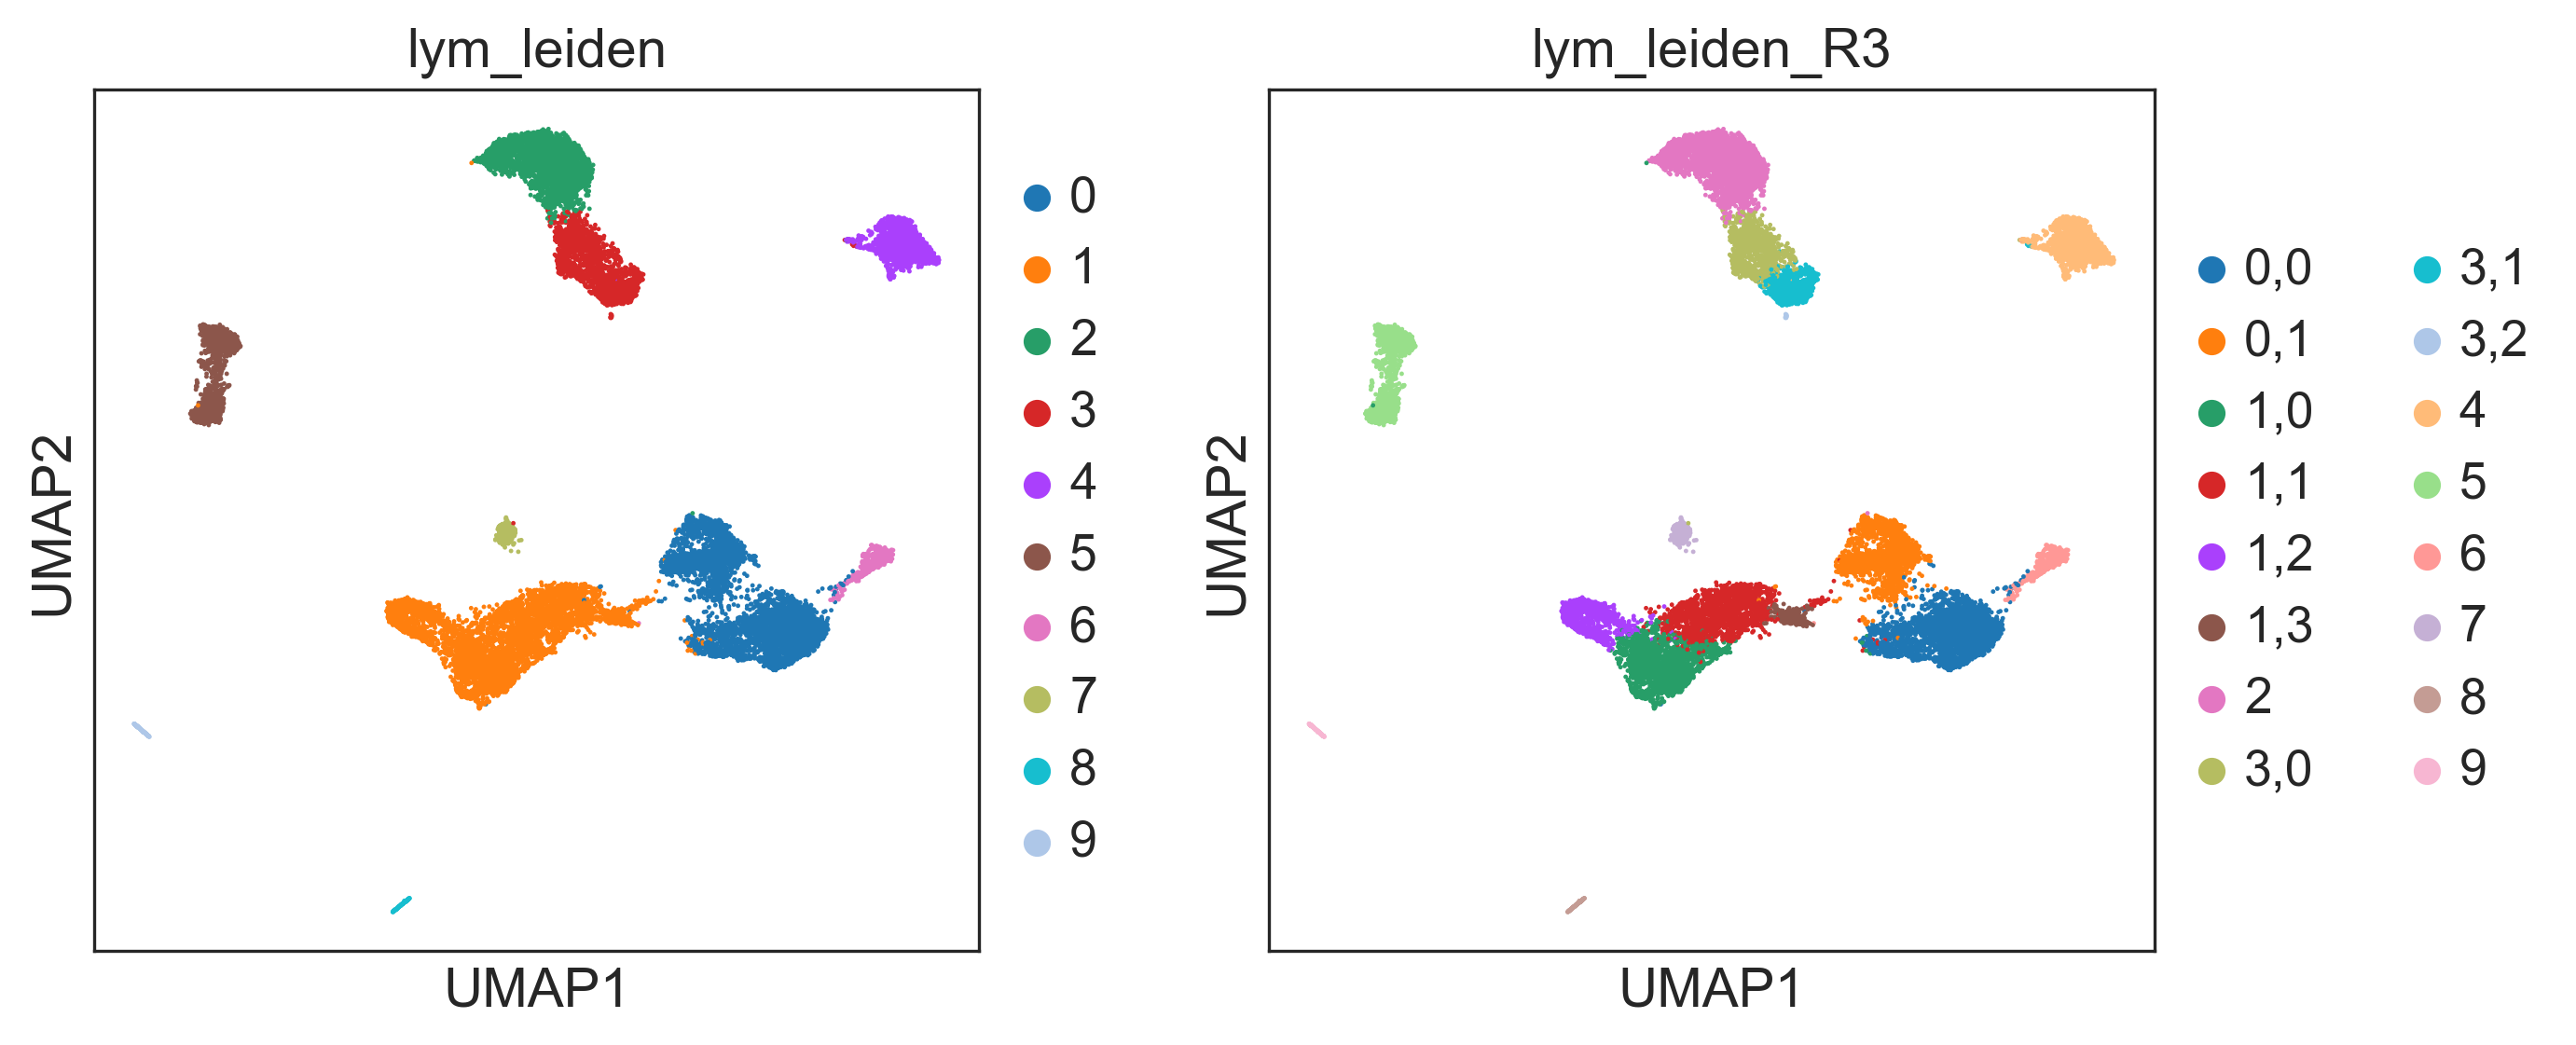

In [23]:
sc.tl.leiden(harmonized, resolution=0.2, restrict_to=('lym_leiden',["0"]),key_added="lym_leiden_R1")
sc.tl.leiden(harmonized, resolution=0.3, restrict_to=('lym_leiden_R1',["1"]),key_added="lym_leiden_R2")
sc.tl.leiden(harmonized, resolution=0.3, restrict_to=('lym_leiden_R2',["3"]),key_added="lym_leiden_R3")
sc.pl.umap(harmonized, 
           color=["lym_leiden","lym_leiden_R3"],
           use_raw=False,
          )

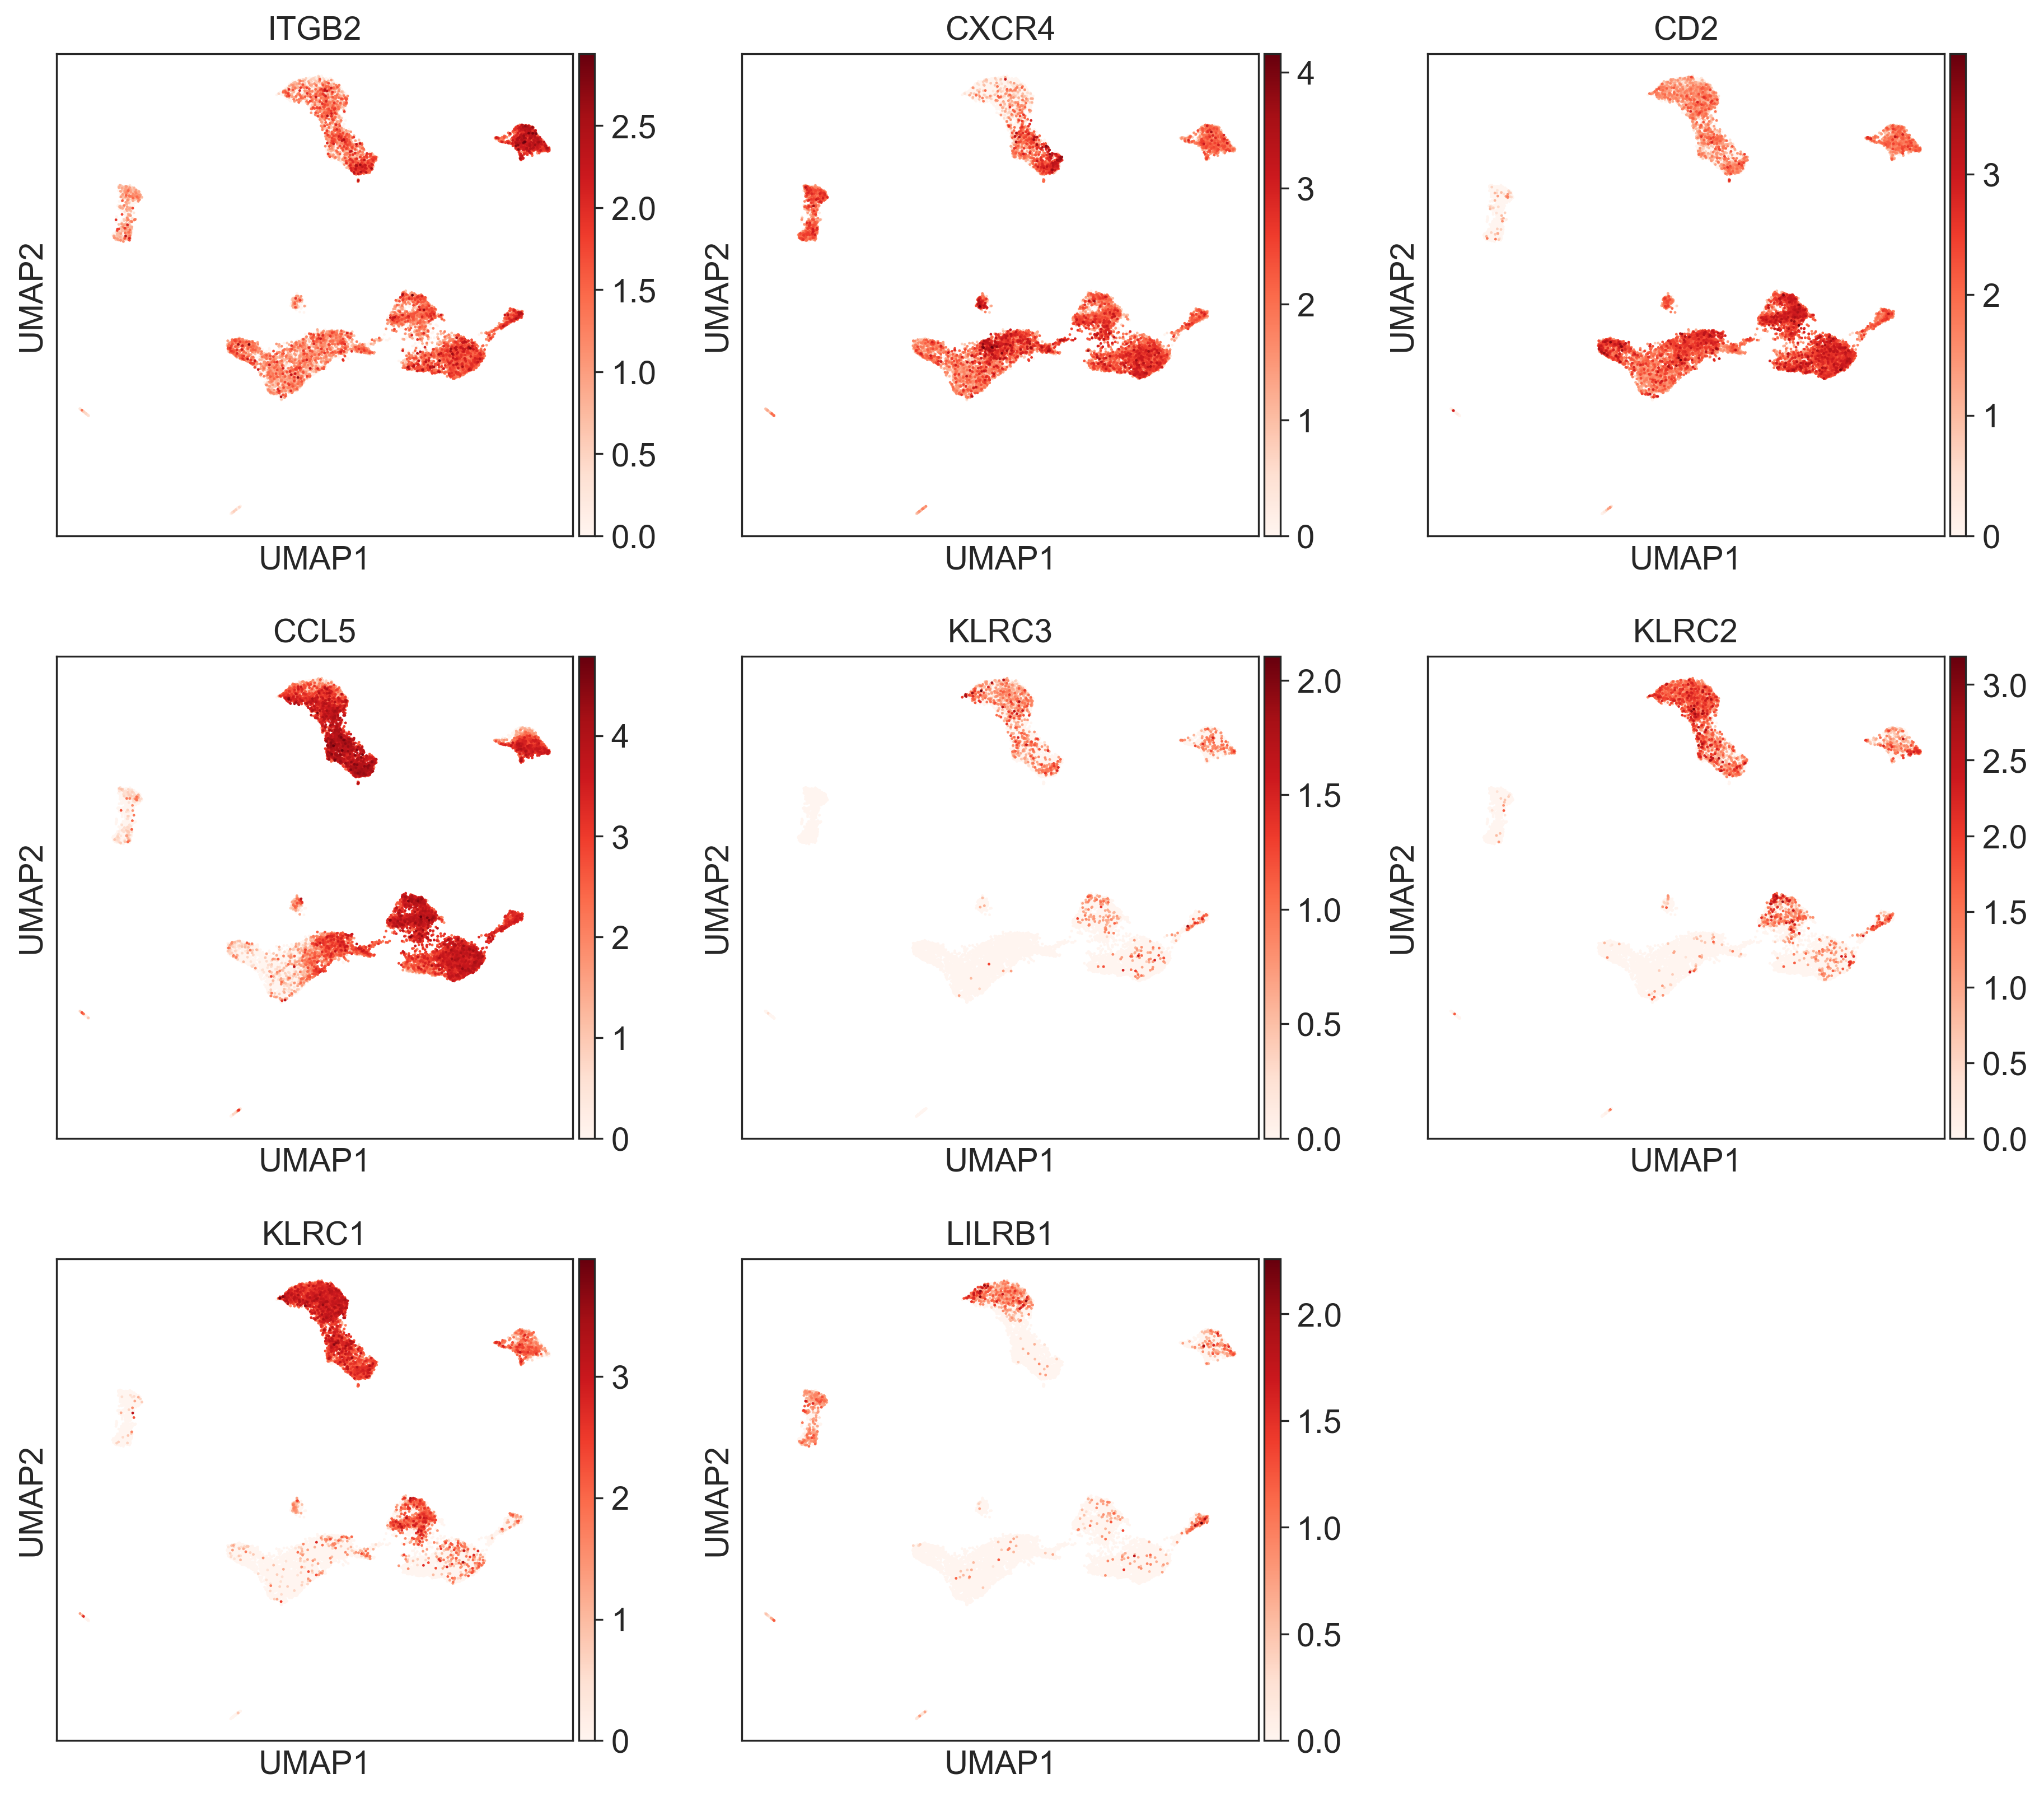

In [24]:
sc.pl.umap(harmonized, color=["ITGB2","CXCR4","CD2","CCL5","KLRC3","KLRC2","KLRC1","LILRB1"],
           ncols=3,use_raw=False,color_map='Reds')

In [25]:
save_adata(harmonized, "harmonized-Lymphocytes", subdir=sub_dir)

---

#### Doublet Identification

***Visible doublet***

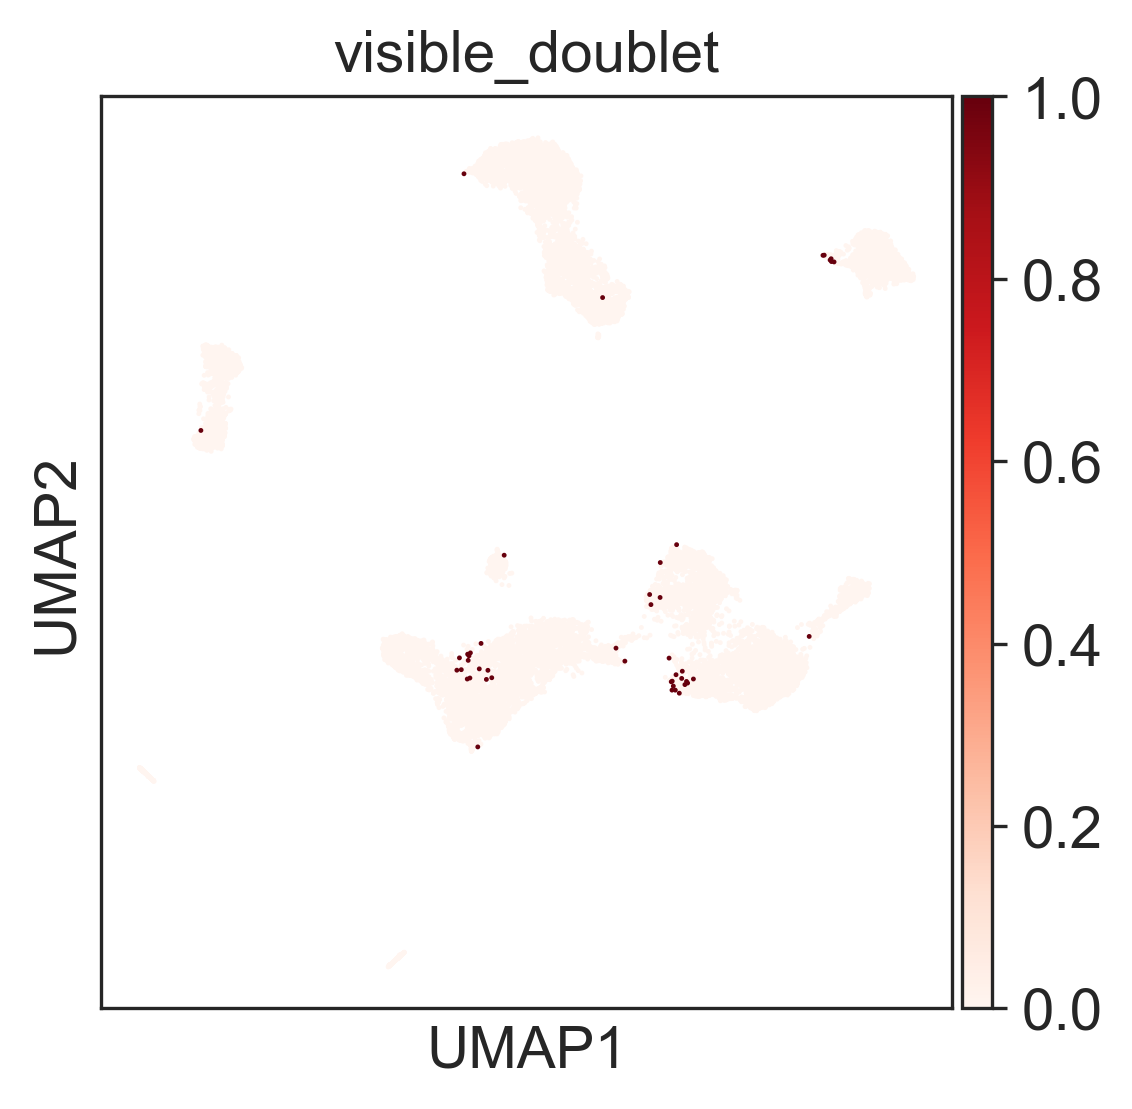

In [27]:
detect_umap_doublets(harmonized, cluster_key= "lym_leiden_R3", t=9)
sc.pl.umap(harmonized,color=["visible_doublet"], color_map="Reds")

In [28]:
clean = harmonized[~harmonized.obs.visible_doublet,:].copy()

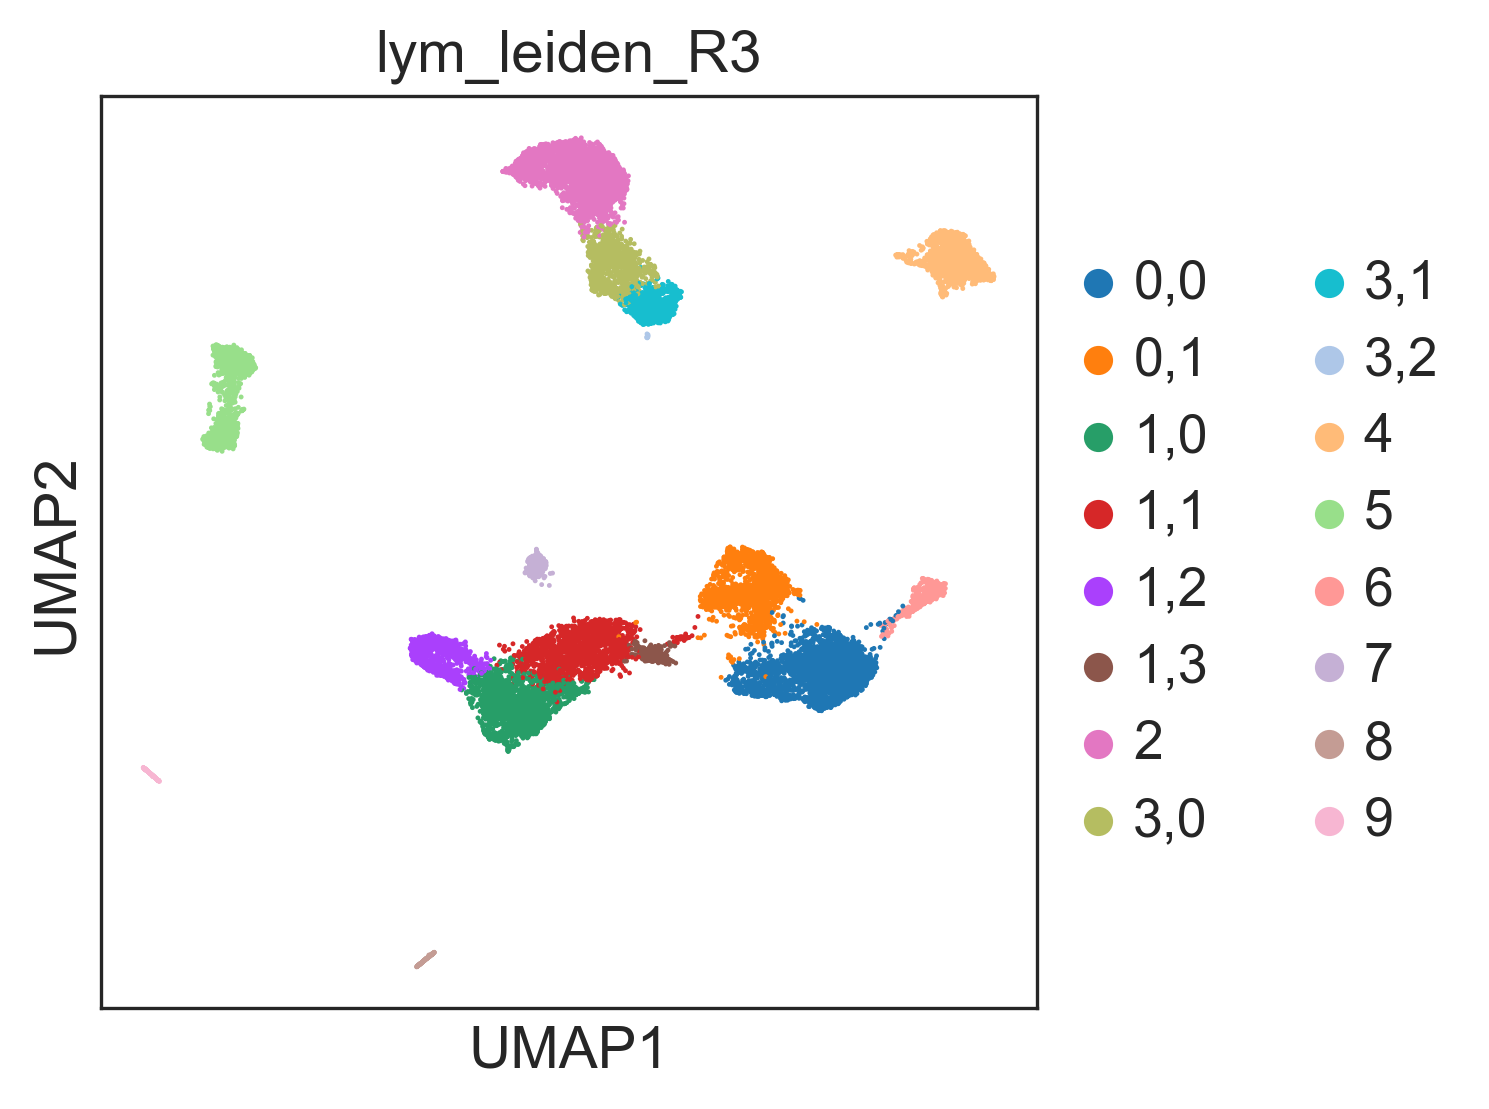

In [29]:
sc.pl.umap(clean, color =["lym_leiden_R3"])

In [31]:
reorder_clusters_hierarchical(clean,cluster_key="lym_leiden_R3",new_key='lym_cluster')

AnnData object with n_obs × n_vars = 22235 × 21799
    obs: 'sequencing_saturation', 'Patient_id', 'stage', 'scrublet_predicted_doublet', 'scrublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mitochondrial', 'log1p_total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_hemoglobin', 'log1p_total_counts_hemoglobin', 'pct_counts_hemoglobin', 'library', '10x_chemistry', 'sample_name', 'sampleid', 'sample_type', 'leiden', 'leiden_R1', 'leiden_R2', 'leiden_R3', 'leiden_R4', 'leiden_R5', 'leiden_R6', 'leiden_R7', 'cluster', 'cluster_R1', 'celltype', 'celltype_main', 'lym_leiden', 'lym_leiden_R1', 'lym_leiden_R2', 'lym_leiden_R3', 'visible_doublet', 'lym_cluster'
    var: 'gene_ids', 'mitochondrial', 'hemoglobin', 'total_counts', 'n_cells_by_counts', 'ribosomal', 'cell_cycle', 'stress_response'

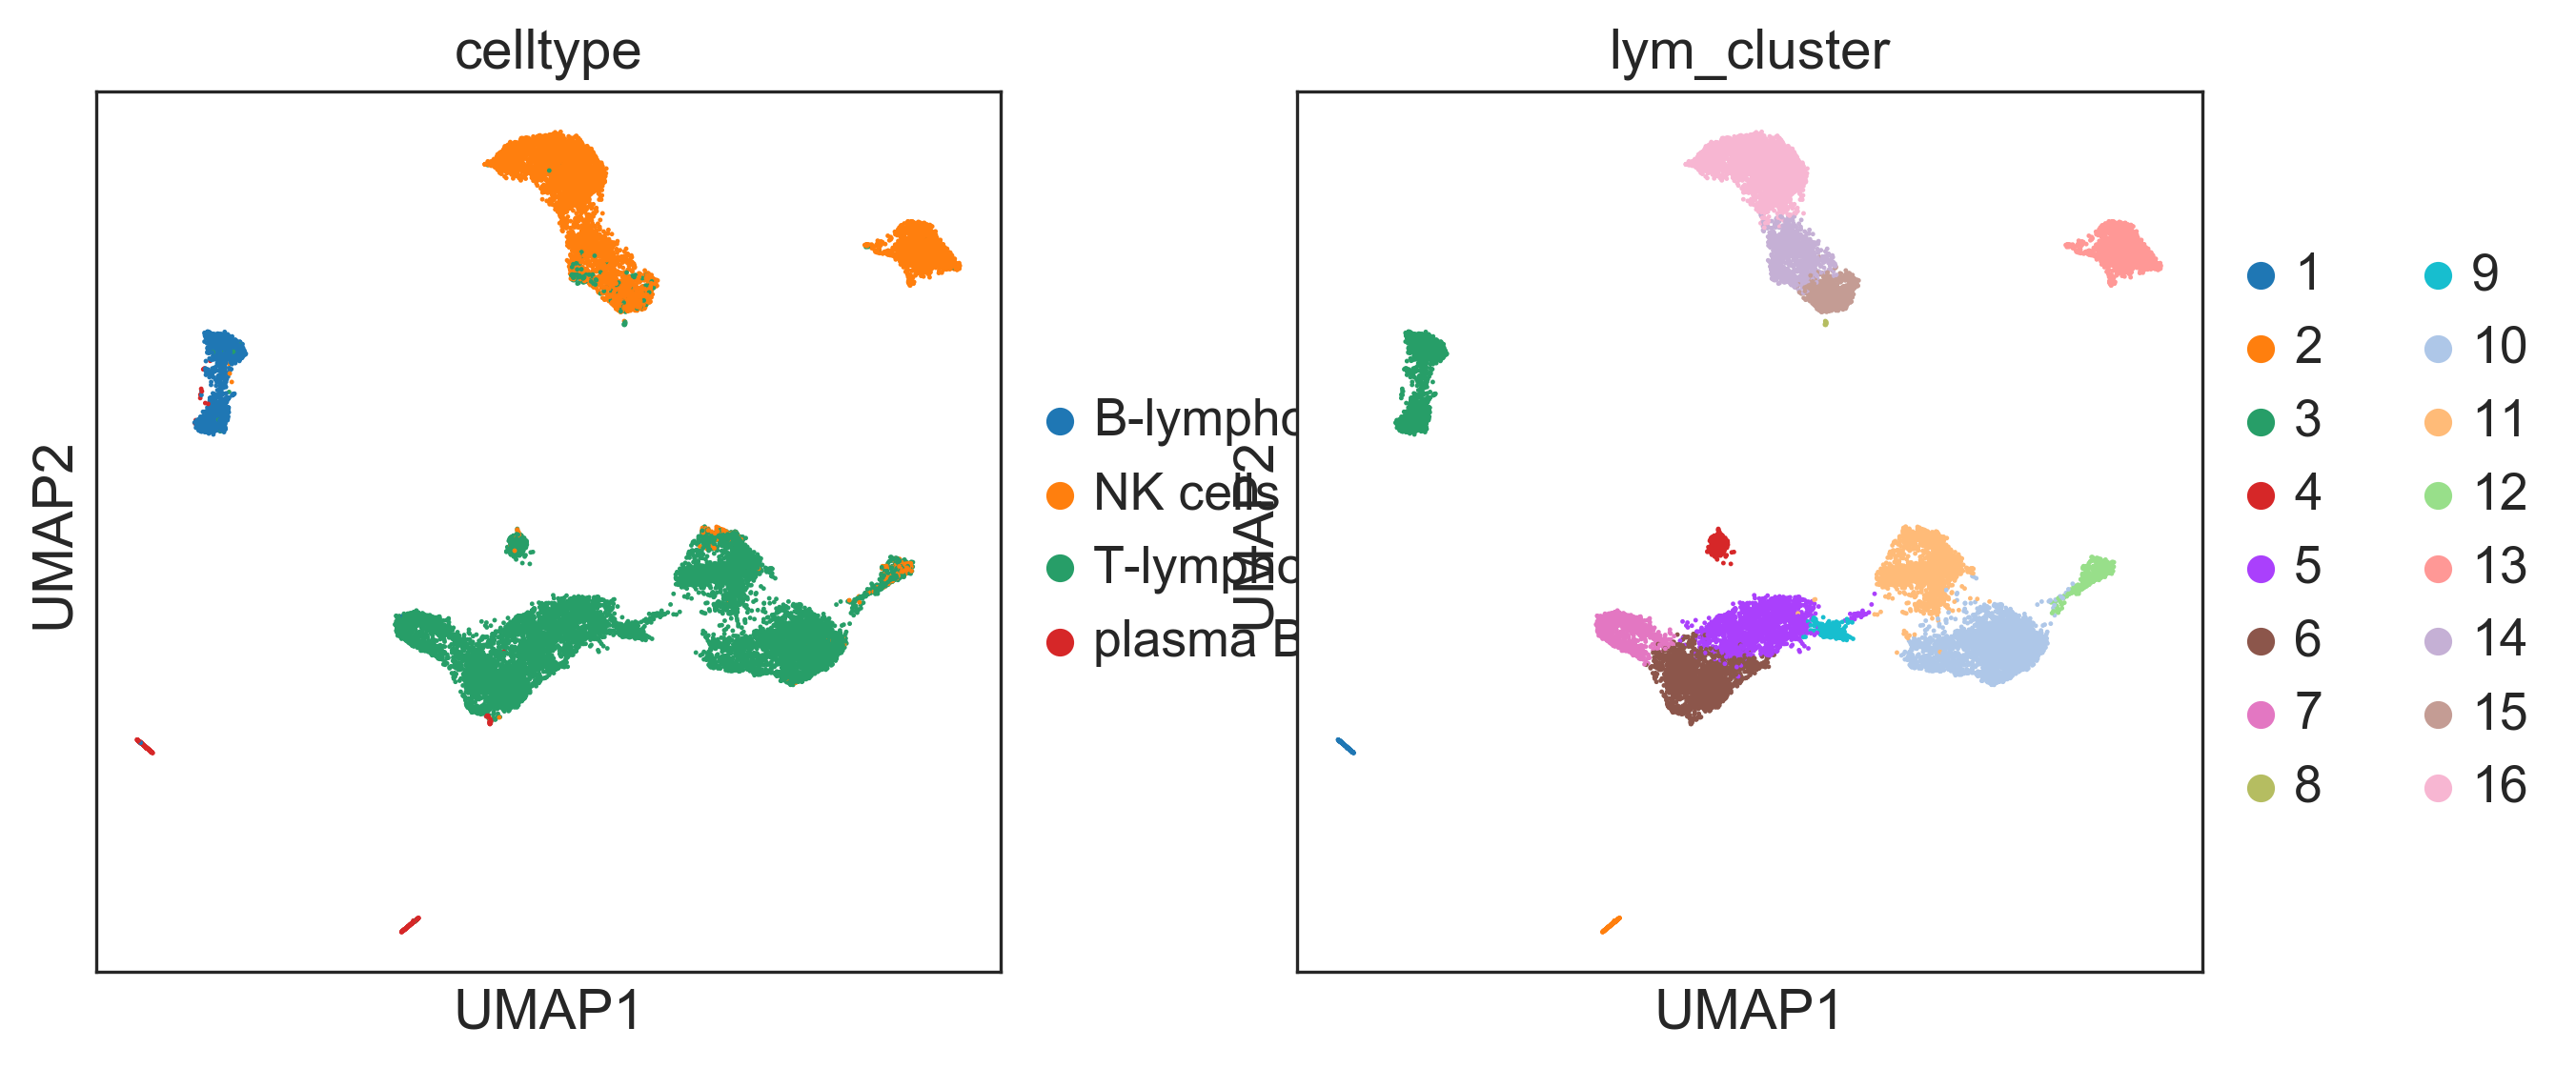

In [32]:
sc.pl.umap(clean, color=["celltype","lym_cluster"])

In [33]:
save_adata(clean,"scrubs-clean-lym",subdir=sub_dir)

---
### Final Subtypes Clustering
date: Jan 04th, 2022
<br> Final clustering based on previous analysis (cell type markers, differential gene expression, literature reviews)

In [6]:
clean = sc.read(f"{main_dir}data/h5ad/{sample_id}/{sub_dir}/{sample_id}-scrubs-clean-lym-20220104.h5ad")

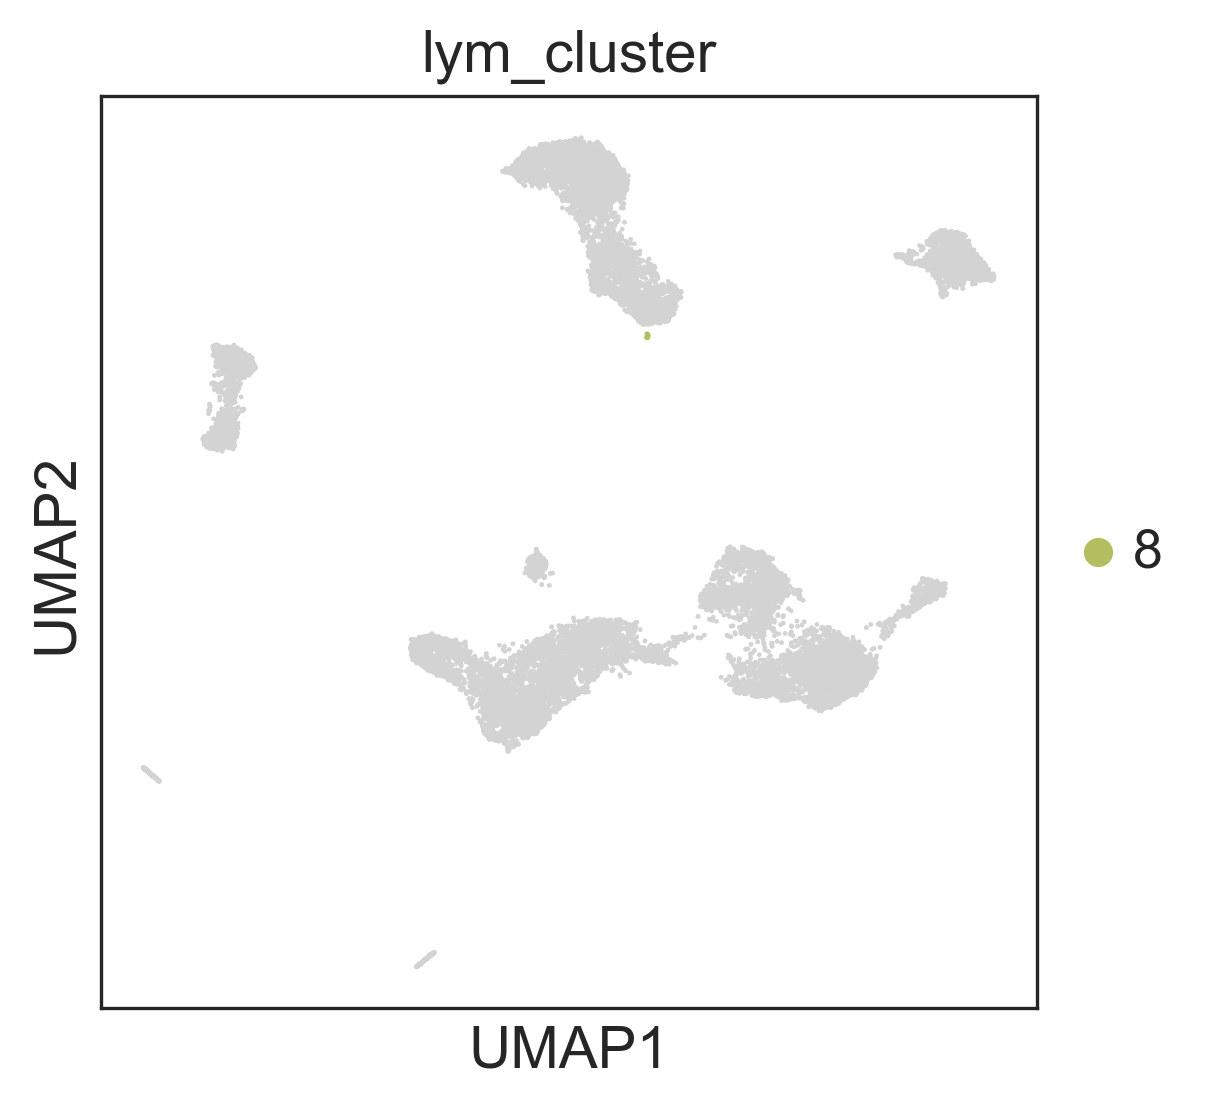

In [38]:
sc.pl.umap(clean, color="lym_cluster", groups="8")

/home/tany/.conda/envs/endometriosis/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
<ipython-input-15-e1bc8612bd56>:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0.025, 0.025, 0.95, 0.95))


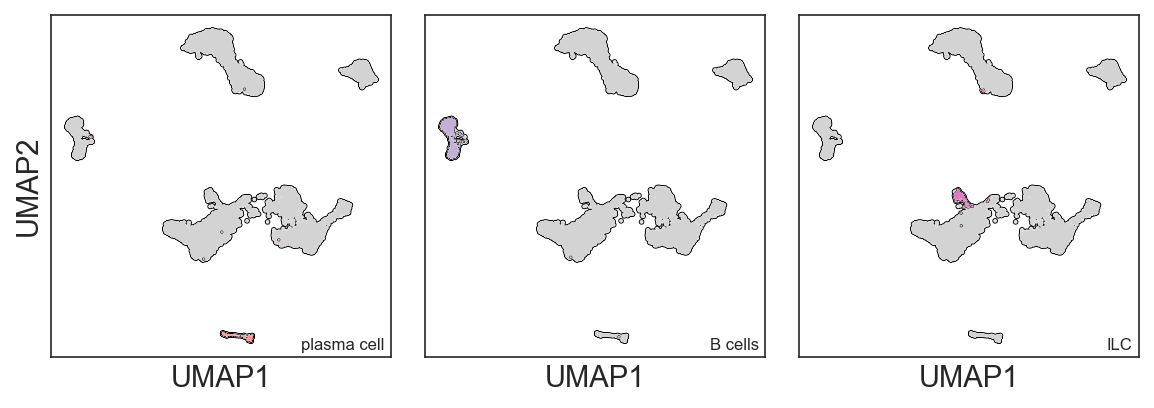

In [15]:
#how's the cells distribution looks like?
fig = plt.figure(figsize=(9.3, 3), facecolor="white")
gs = plt.GridSpec(1, 3,wspace=0.1)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
axs = [ax1,ax2,ax3]

main_cluster = clean.copy()
params = dict(show=False, title="", add_outline=True, legend_loc=None)
biopsy_origins = "plasma cell","B cells","ILC"
number_of_cells = "0 cells","0 cells","0 cells"
#sample_type_palette=[get_xkcd[6],get_xkcd[5],get_xkcd[4]]

for k in range(len(axs)):
    ax = axs[k]
    sc.pl.umap(
        main_cluster, s=10, 
        ax=ax,
        **params
    ) 
    biopsys = biopsy_origins[k]
    n_cells = number_of_cells[k]
    sc.pl.umap(
        main_cluster[main_cluster.obs.old_subtypes.isin([biopsys])], s=3,
        color="old_subtypes",
        #palette=[sample_type_palette[k]],
        ax=ax,
        **params
    )
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.text(0.98, 0.02, biopsys, transform=ax.transAxes, ha="right", fontsize=8)
    #ax.text(0.98, 0.94, n_cells, transform=ax.transAxes, ha="right", fontsize=8)
ax1.set_ylabel("UMAP2",)
ax1.set_xlabel("UMAP1")
ax2.set_xlabel("UMAP1")
ax3.set_xlabel("UMAP1")
fig.tight_layout(rect=(0.025, 0.025, 0.95, 0.95))
#fig.savefig("u01_umap.png", bbox_inches="tight", dpi=300)
#save_figure(fig, pdir="Fig_1", name="sample_type")

---

In [ ]:
#what the differences in the 2 cluster of B-cells and plasma cells? 

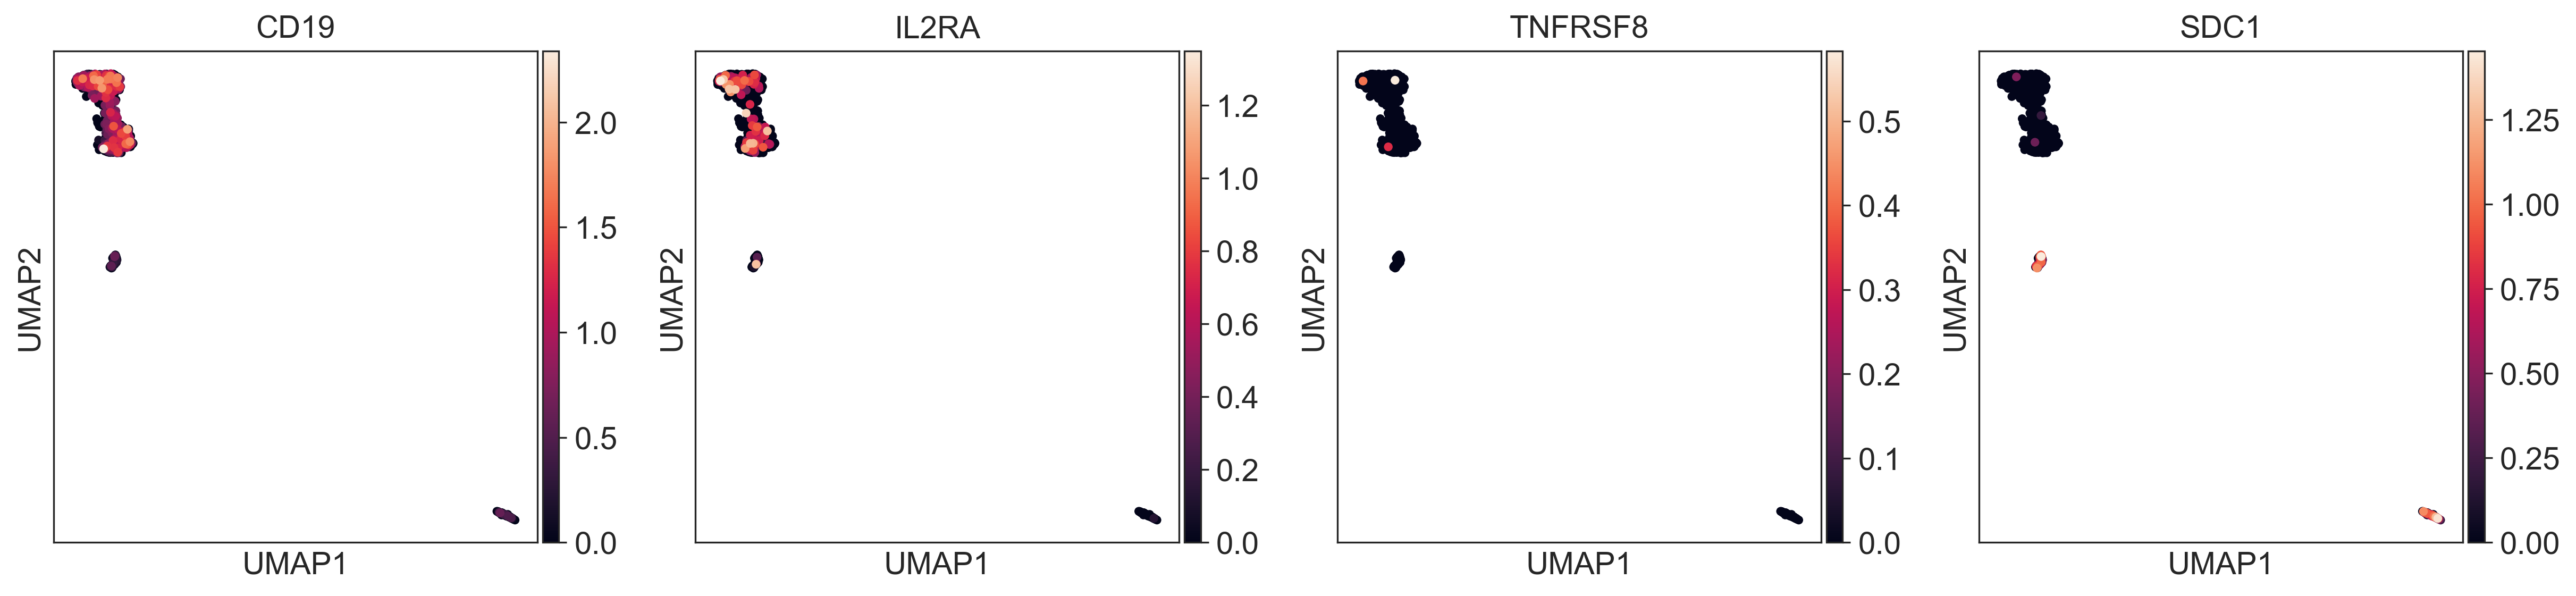

In [83]:
sc.pl.umap(clean[clean.obs.lym_cluster.isin(["1","2","3","4"])], color=["CD19","IL2RA","TNFRSF8","SDC1"])

Filtering genes using: min_in_group_fraction: 0.8 min_fold_change: 0.5, max_out_group_fraction: 0.3
categories: 1, 2, 3, etc.
var_group_labels: 1, 2, 3, etc.


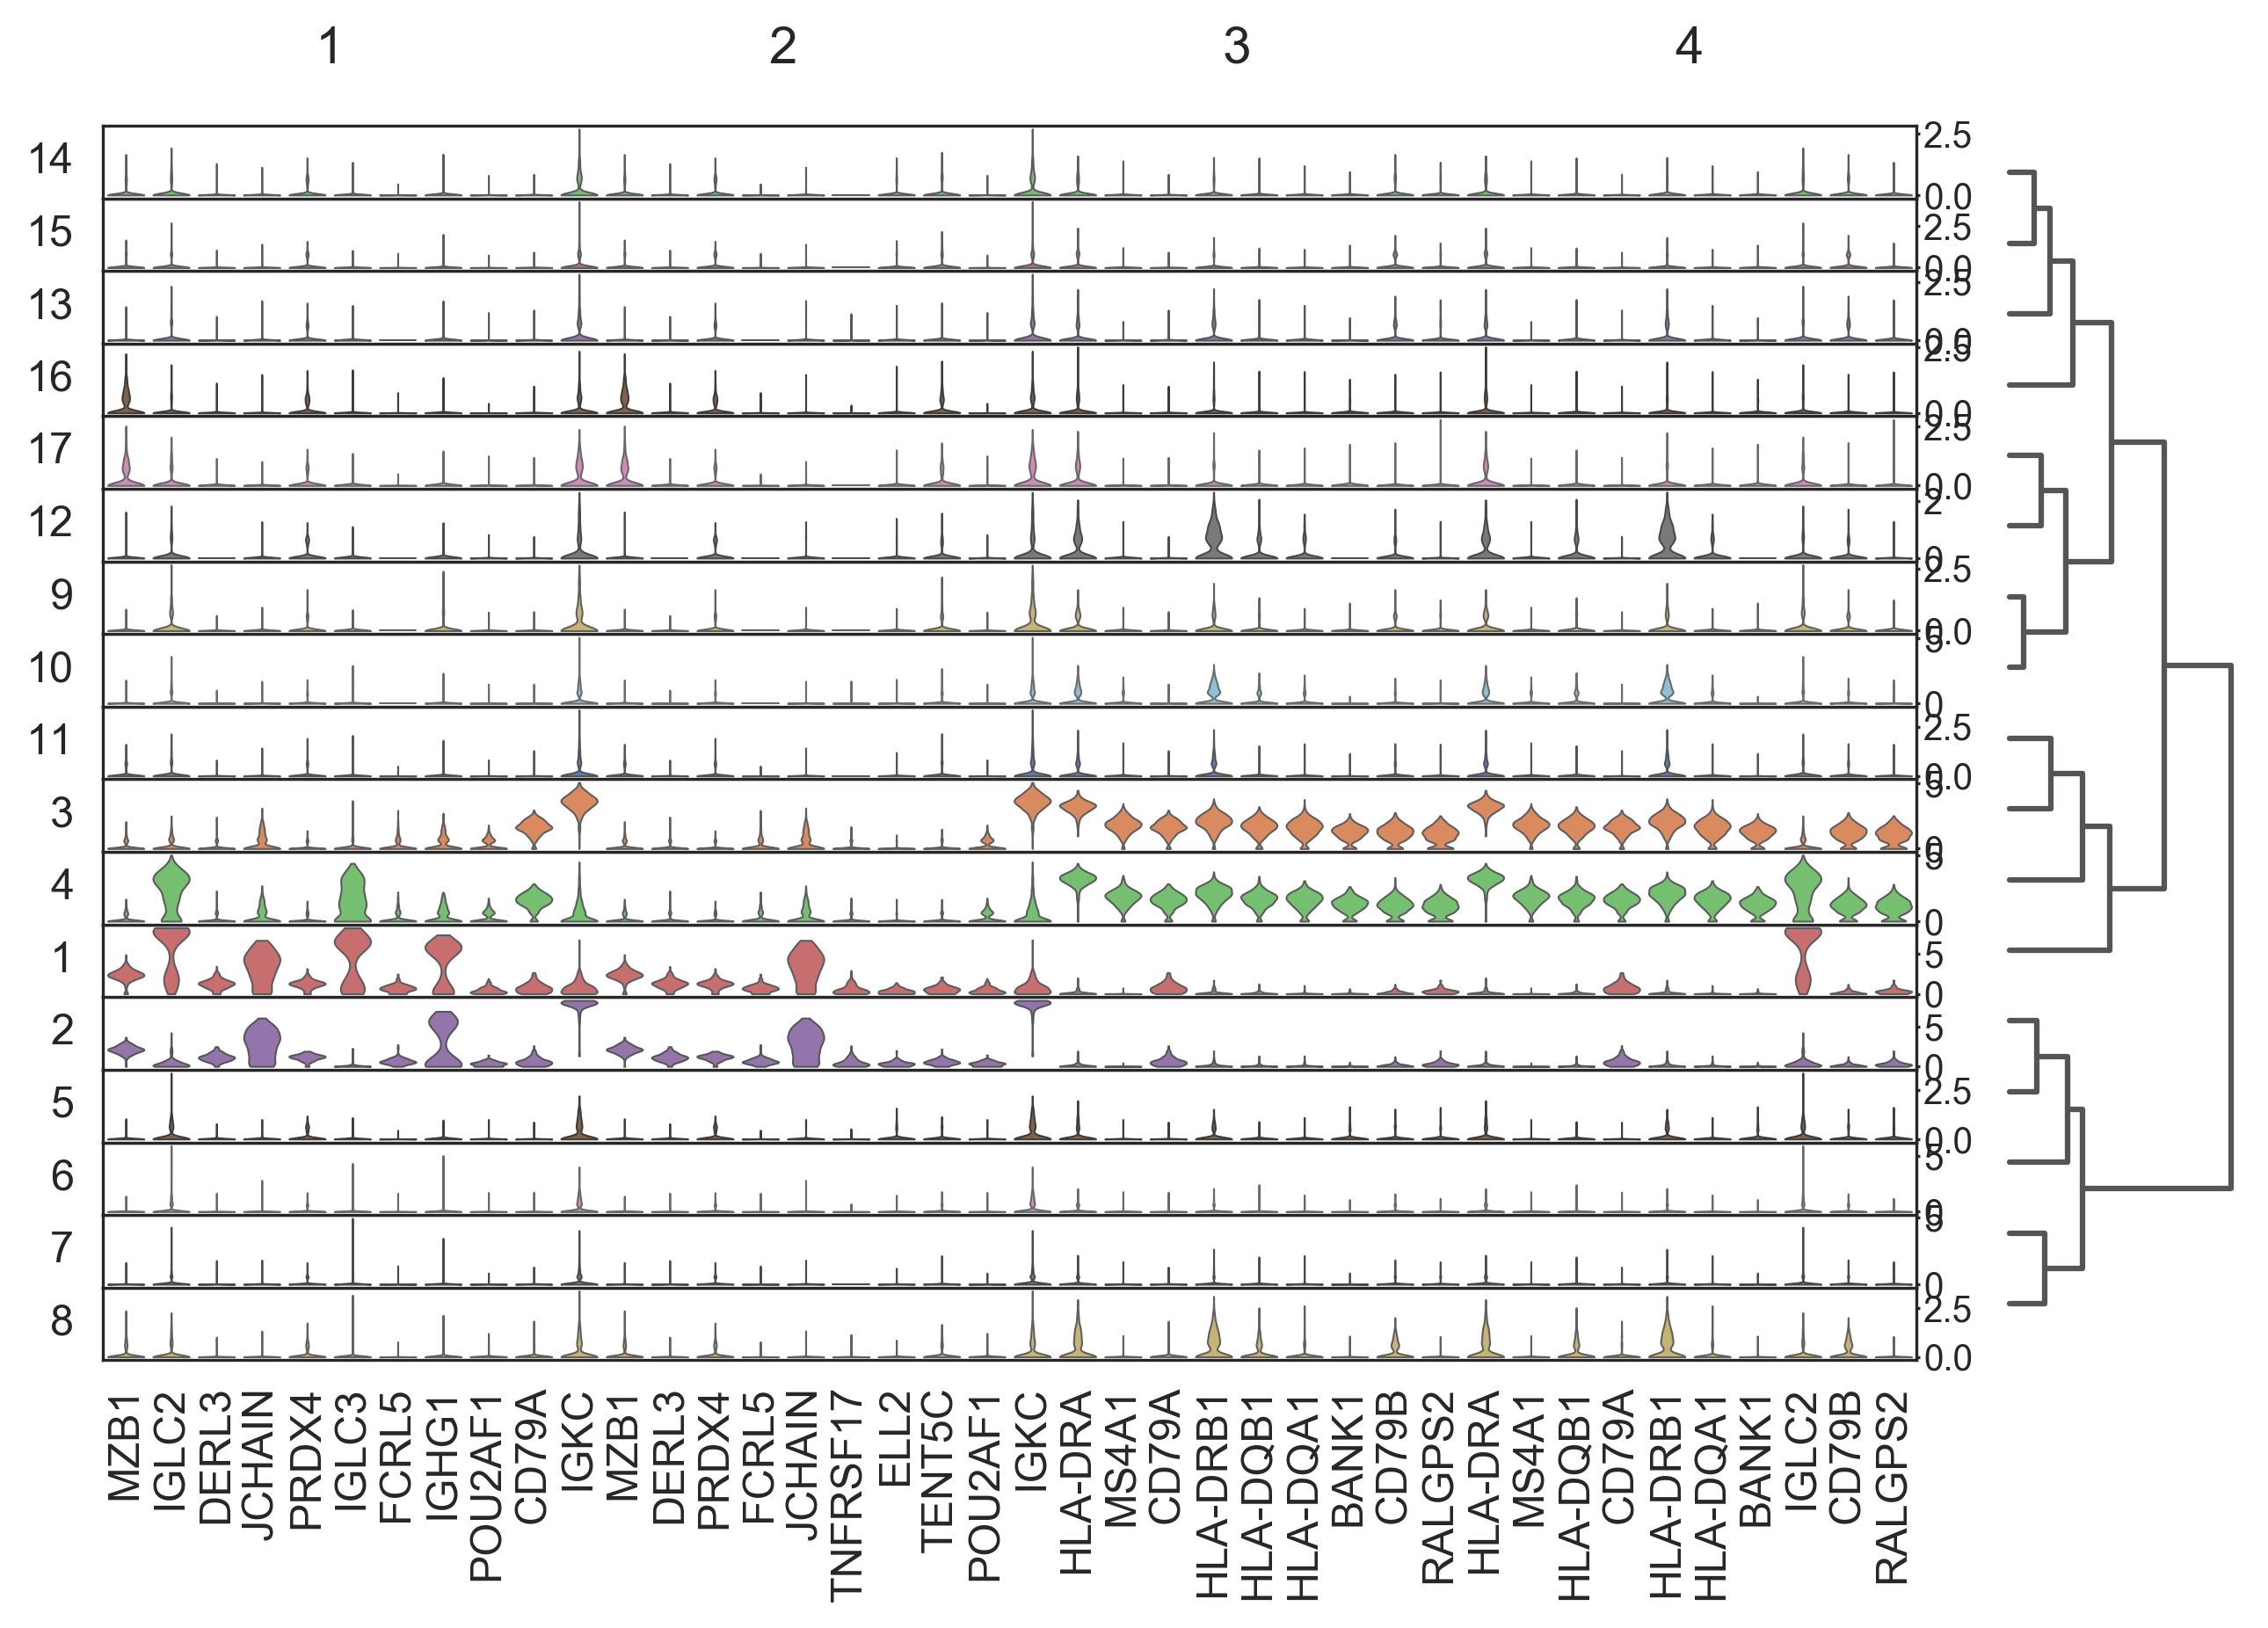

In [80]:
sc.tl.filter_rank_genes_groups(clean_copy,use_raw=False,
                               min_in_group_fraction=0.8, max_out_group_fraction=0.3, min_fold_change=0.5)
sc.pl.rank_genes_groups_stacked_violin(clean_copy, key='rank_genes_groups_filtered', n_genes=10)

They have different clonality! (see above)

---

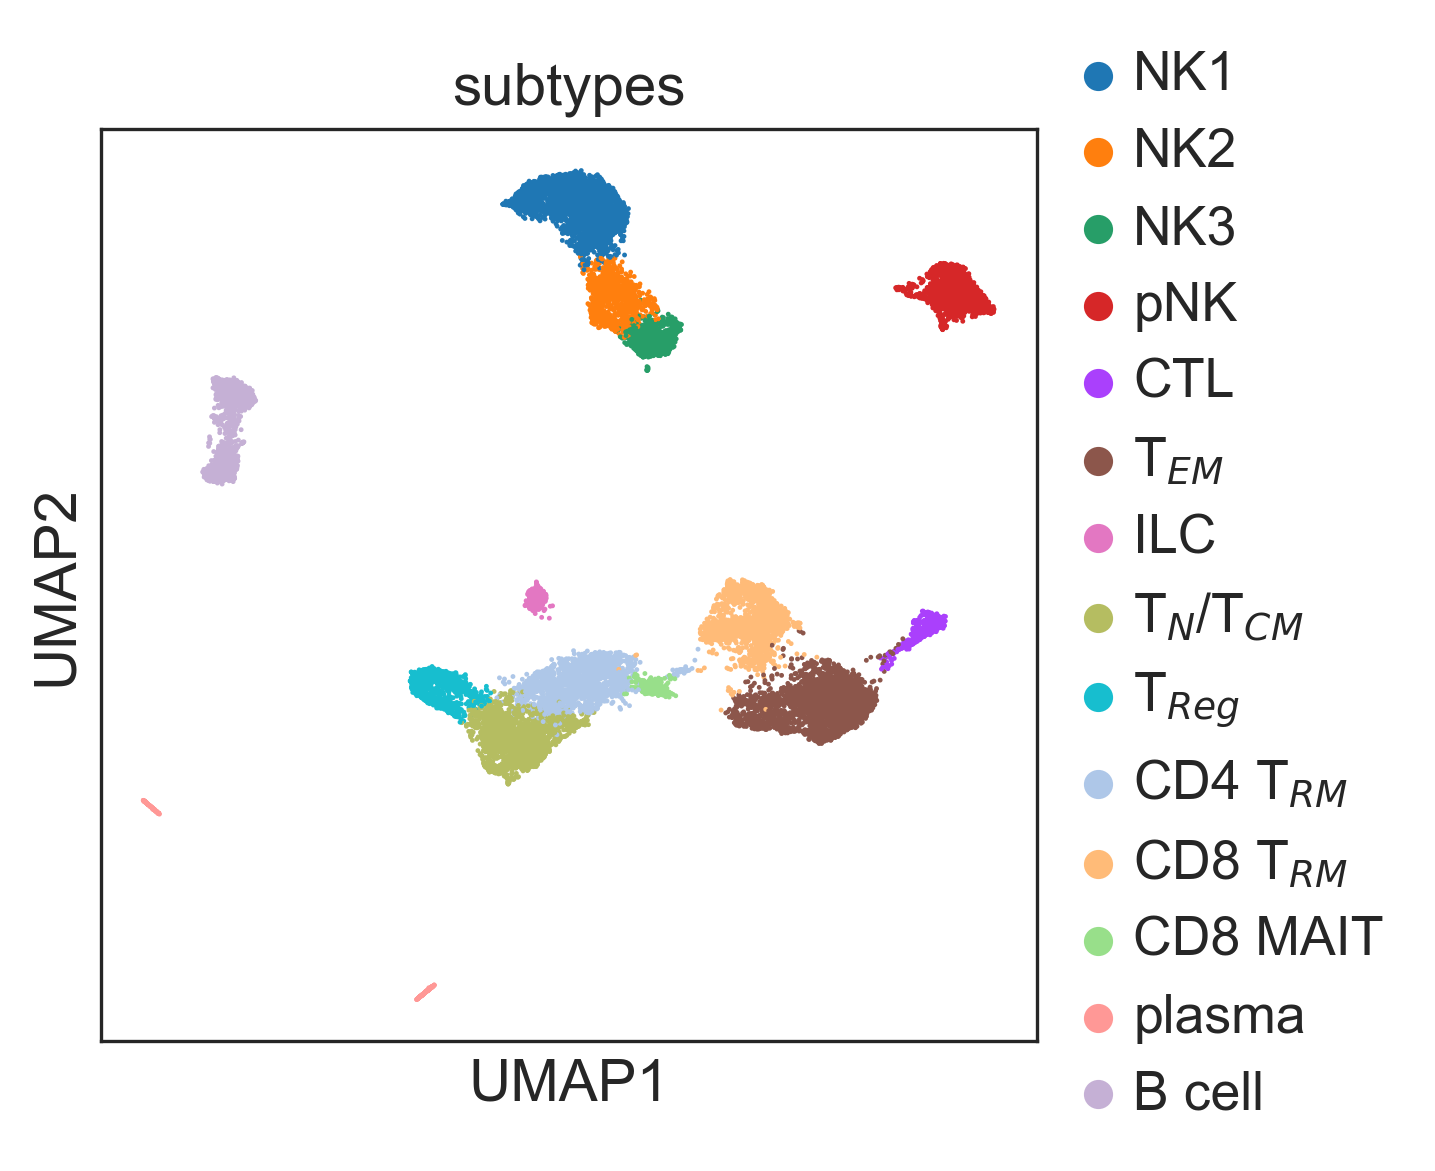

In [46]:
clean.obs["subtypes"] = clean.obs.lym_cluster.map({
    "1":"plasma",
    "2":"plasma",
    "3":"B cell",
    "4":"ILC",
    "5":"CD4 T$_{RM}$",
    "6":"T$_N$/T$_{CM}$",
    "7":"T$_{Reg}$",
    "8":"NK3", #maybe doublets between NK and T cells.
    "10":"T$_{EM}$",
    "9":"CD8 MAIT",
    "11":"CD8 T$_{RM}$",
    "12":"CTL",
    "13":"pNK",
    "14":"NK2",
    "15":"NK3",
    "16":"NK1",
}).astype("category")

clean.obs["subtypes"].cat.reorder_categories([
    "NK1","NK2","NK3","pNK","CTL",
    "T$_{EM}$","ILC","T$_N$/T$_{CM}$","T$_{Reg}$","CD4 T$_{RM}$","CD8 T$_{RM}$","CD8 MAIT",
    "plasma", "B cell"
],
    inplace=True)

sc.pl.umap(clean, color=["subtypes"])

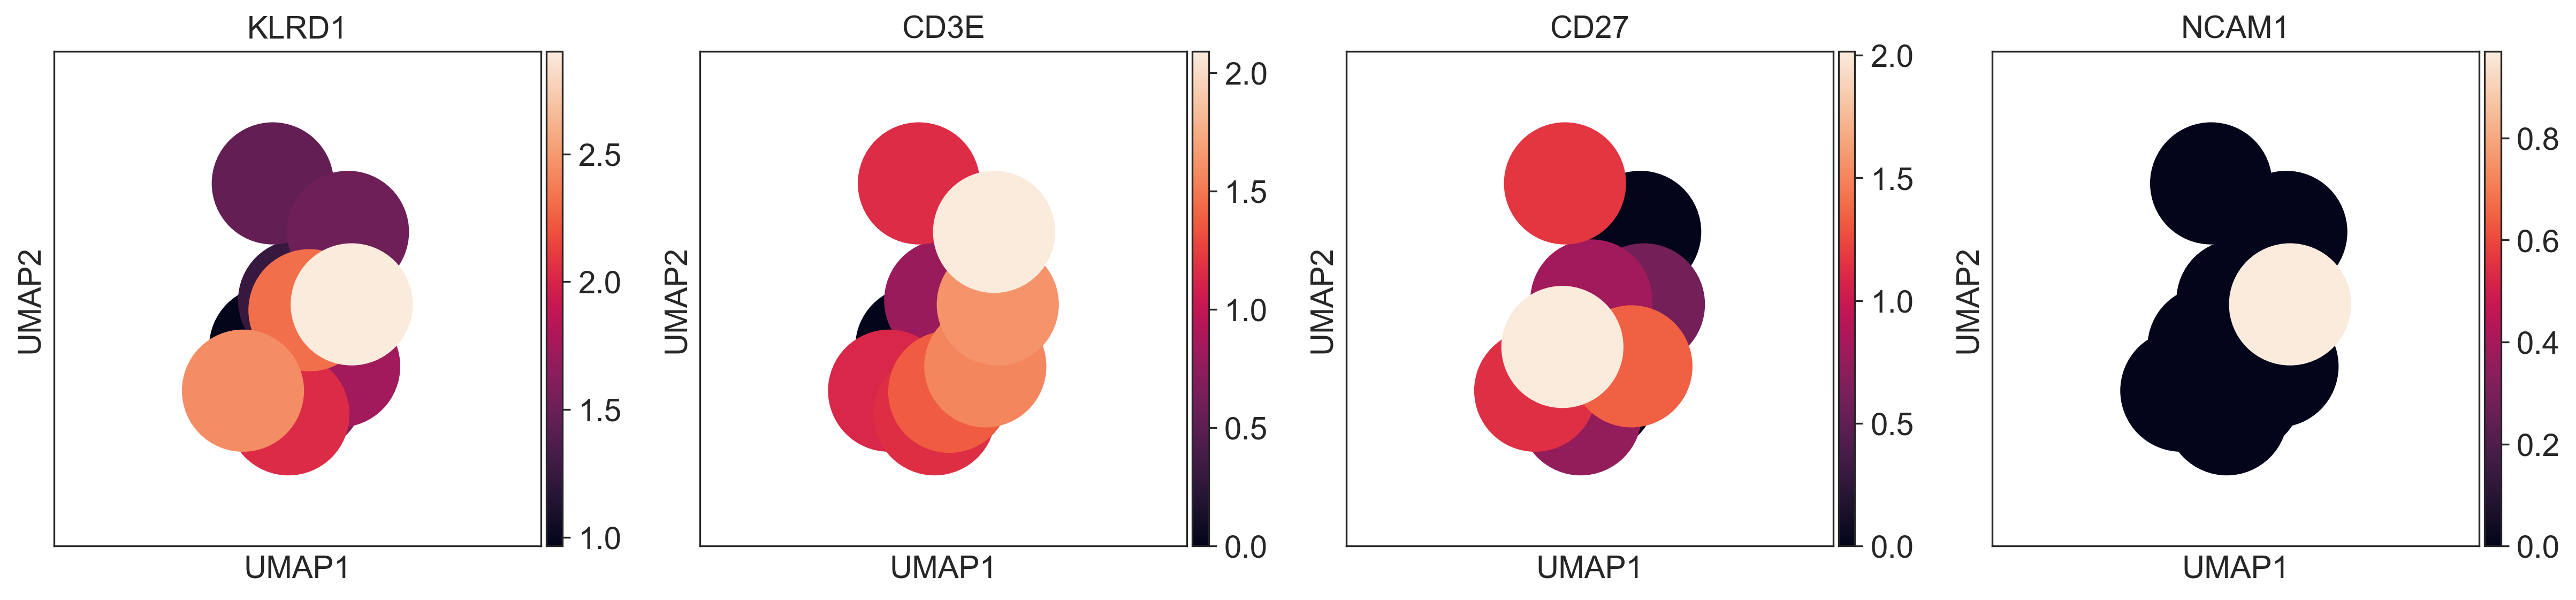

In [59]:
#weird little cluster "8"
sc.pl.umap(clean[clean.obs.lym_cluster == "8"], color=["KLRD1","CD3E","CD27","NCAM1"])
#looks like debri/doublets, mix of multi markers

In [62]:
clean = clean[clean.obs.lym_cluster != "8"].copy()

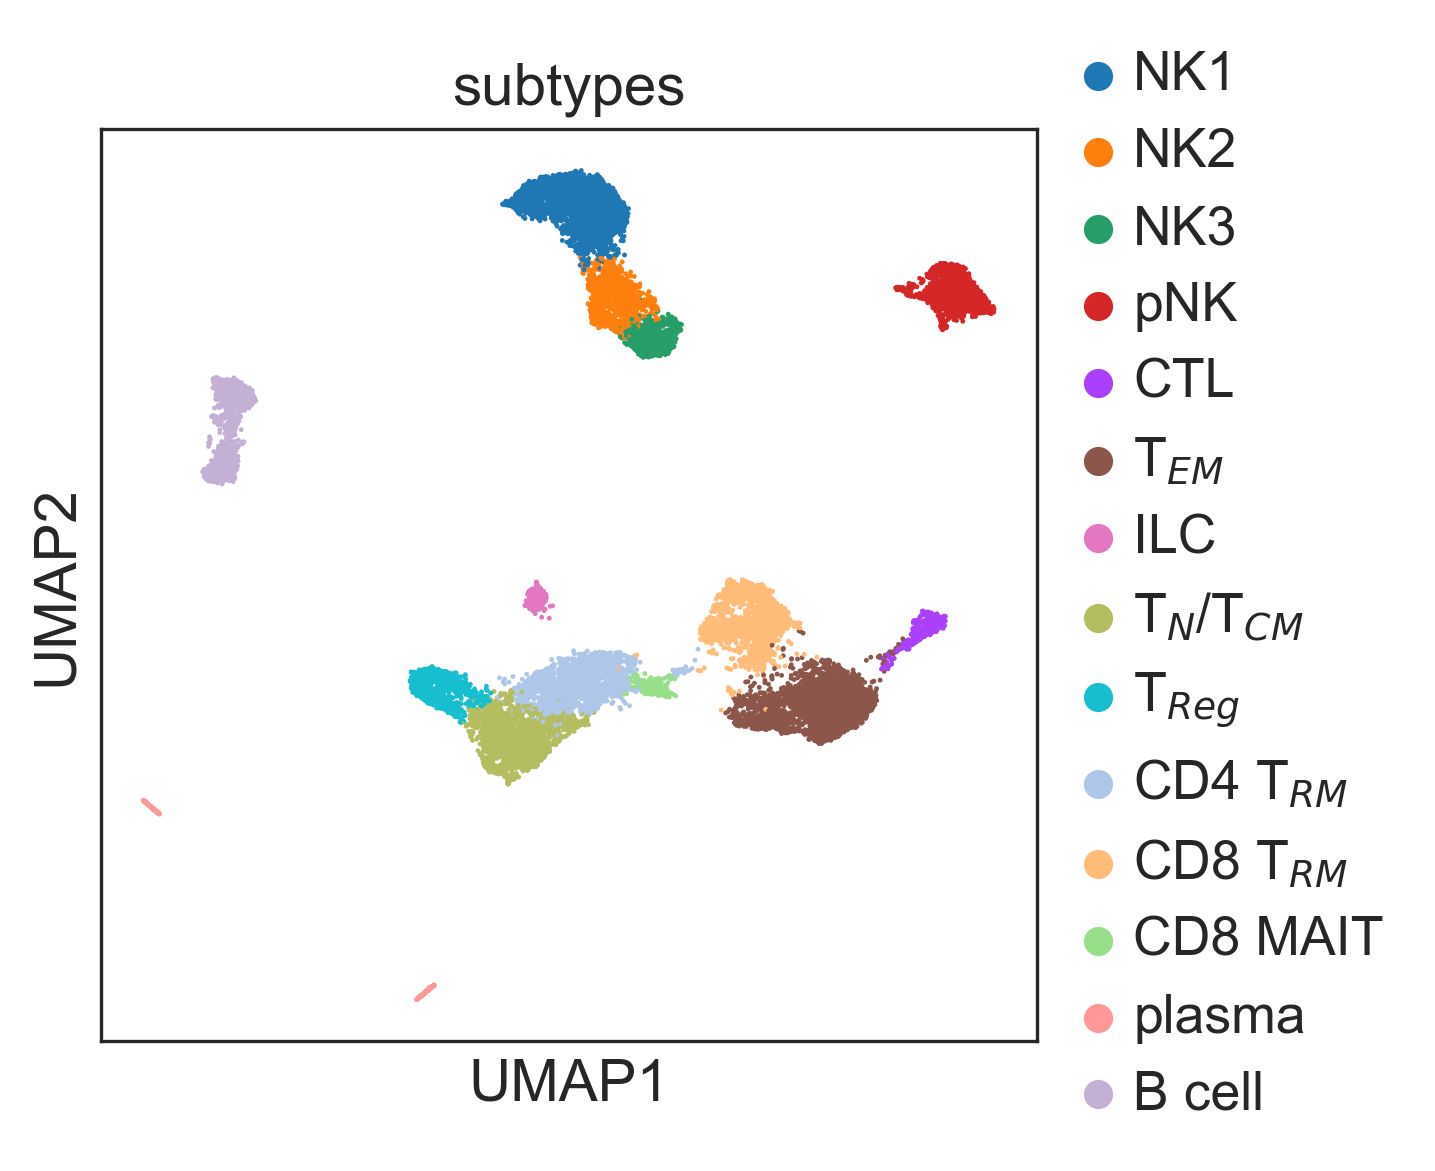

In [63]:
sc.pl.umap(clean, color=["subtypes"])

In [64]:
save_adata(clean,"final-lym",subdir=sub_dir)

---

***Cell_type Markers***

Note:
`sc.tl.rank_genes_groups(adata, groupby="cluster",use_raw=False,)` and `sc.tl.filter_rank_genes_groups(clean, use_raw=False)` will cause warning for adata saving, and subsequently error in adata loading. Copy the adata and run this function for doublet identification purpose. Once `doublet` identified, filter and save the original `adata`.

In [65]:
clean_copy = clean.copy()
#clean_copy.raw = sc.AnnData(clean_copy.layers["raw"], var=clean_copy.var, obs=clean_copy.obs)
clean_copy.raw = clean_copy
sc.tl.rank_genes_groups(clean_copy, groupby="subtypes",use_raw=False, method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:32)


Filtering genes using: min_in_group_fraction: 0.8 min_fold_change: 1, max_out_group_fraction: 0.4
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_subtypes']`


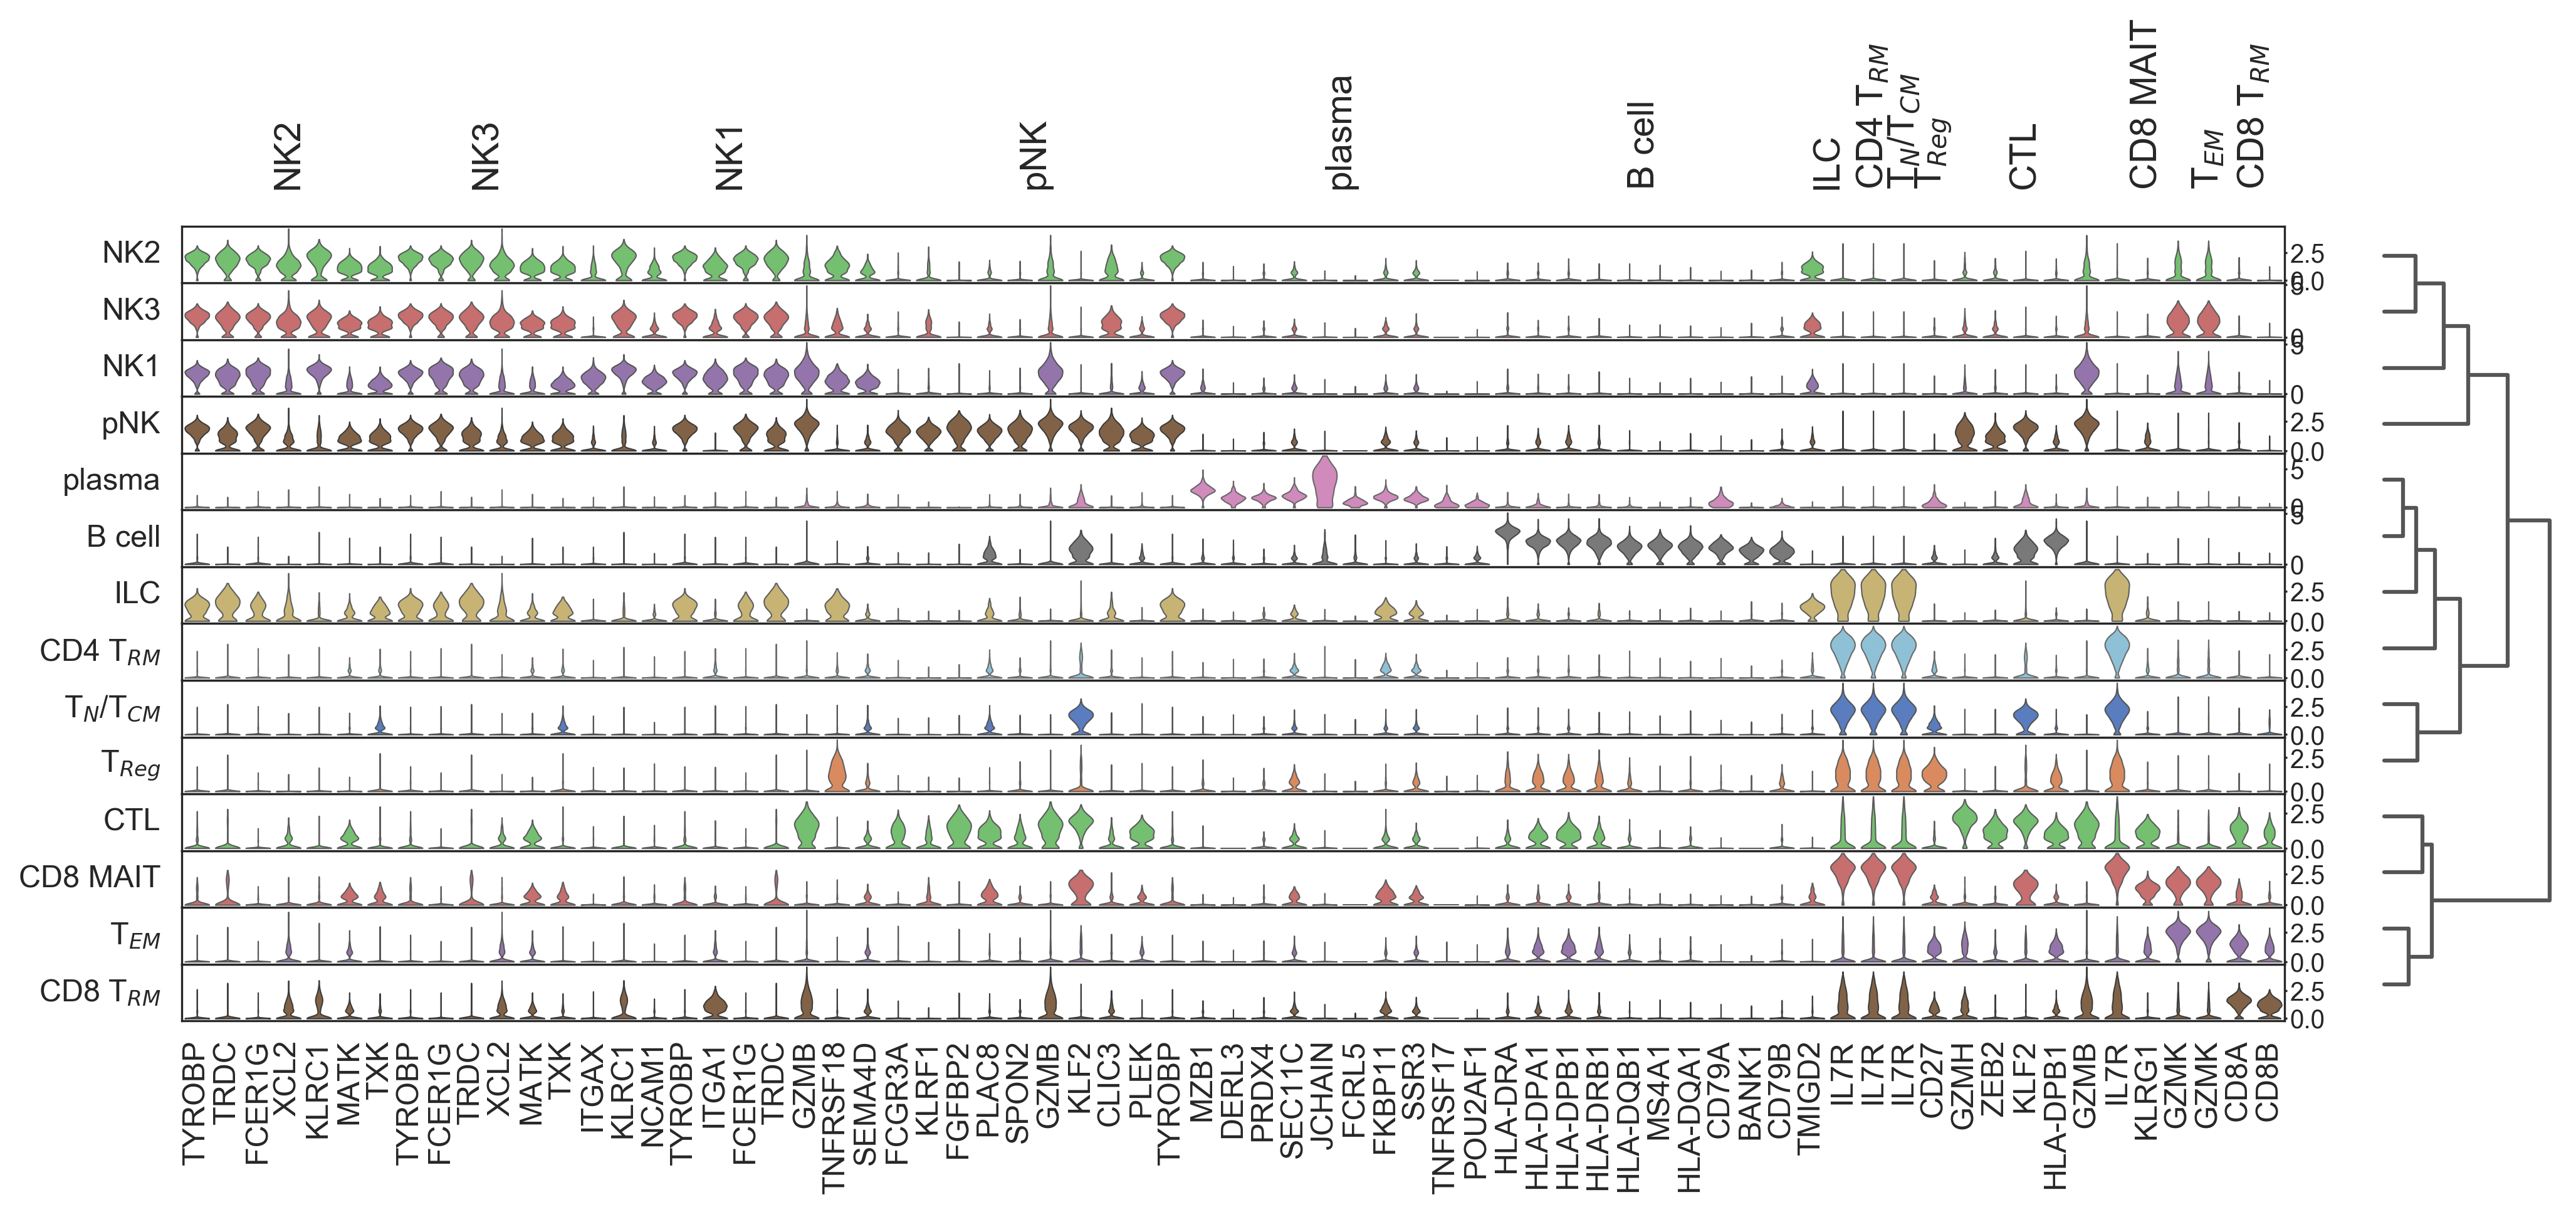

In [66]:
sc.tl.filter_rank_genes_groups(clean_copy,use_raw=False,
                               min_in_group_fraction=0.8, max_out_group_fraction=0.4, min_fold_change=1)
sc.pl.rank_genes_groups_stacked_violin(clean_copy, key='rank_genes_groups_filtered', n_genes=10)

In [67]:
Bcells = ["IGKC","MZB1","DERL3","CD79A","CD79B","MS4A1","BANK1"]
Tcells = ["FGFBP2","TBX21", #CTL
          "IL7R","CD4","CD8A","CD8B","ZNF683", #Tcells
          "CCR7","SELL","TCF7","LEF1","GZMK", #Tn/cm (4), Tem(1)
          "GNLY","CTLA4","FOXP3", #Treg
          "CXCR6","ITGAE", #CD4 Trm
          "XCL1","XCL2","ITGAE","TMIGD2", #CD8 Trm
          "SLC4A10", #CD8 MAIT
         ]
NK = ["FCGR3A","KLRD1","ITGA1","LILRB1","KLRC1","ITGAX","ITGB2","GZMH"]
ILC=["NCR3","RORC"]

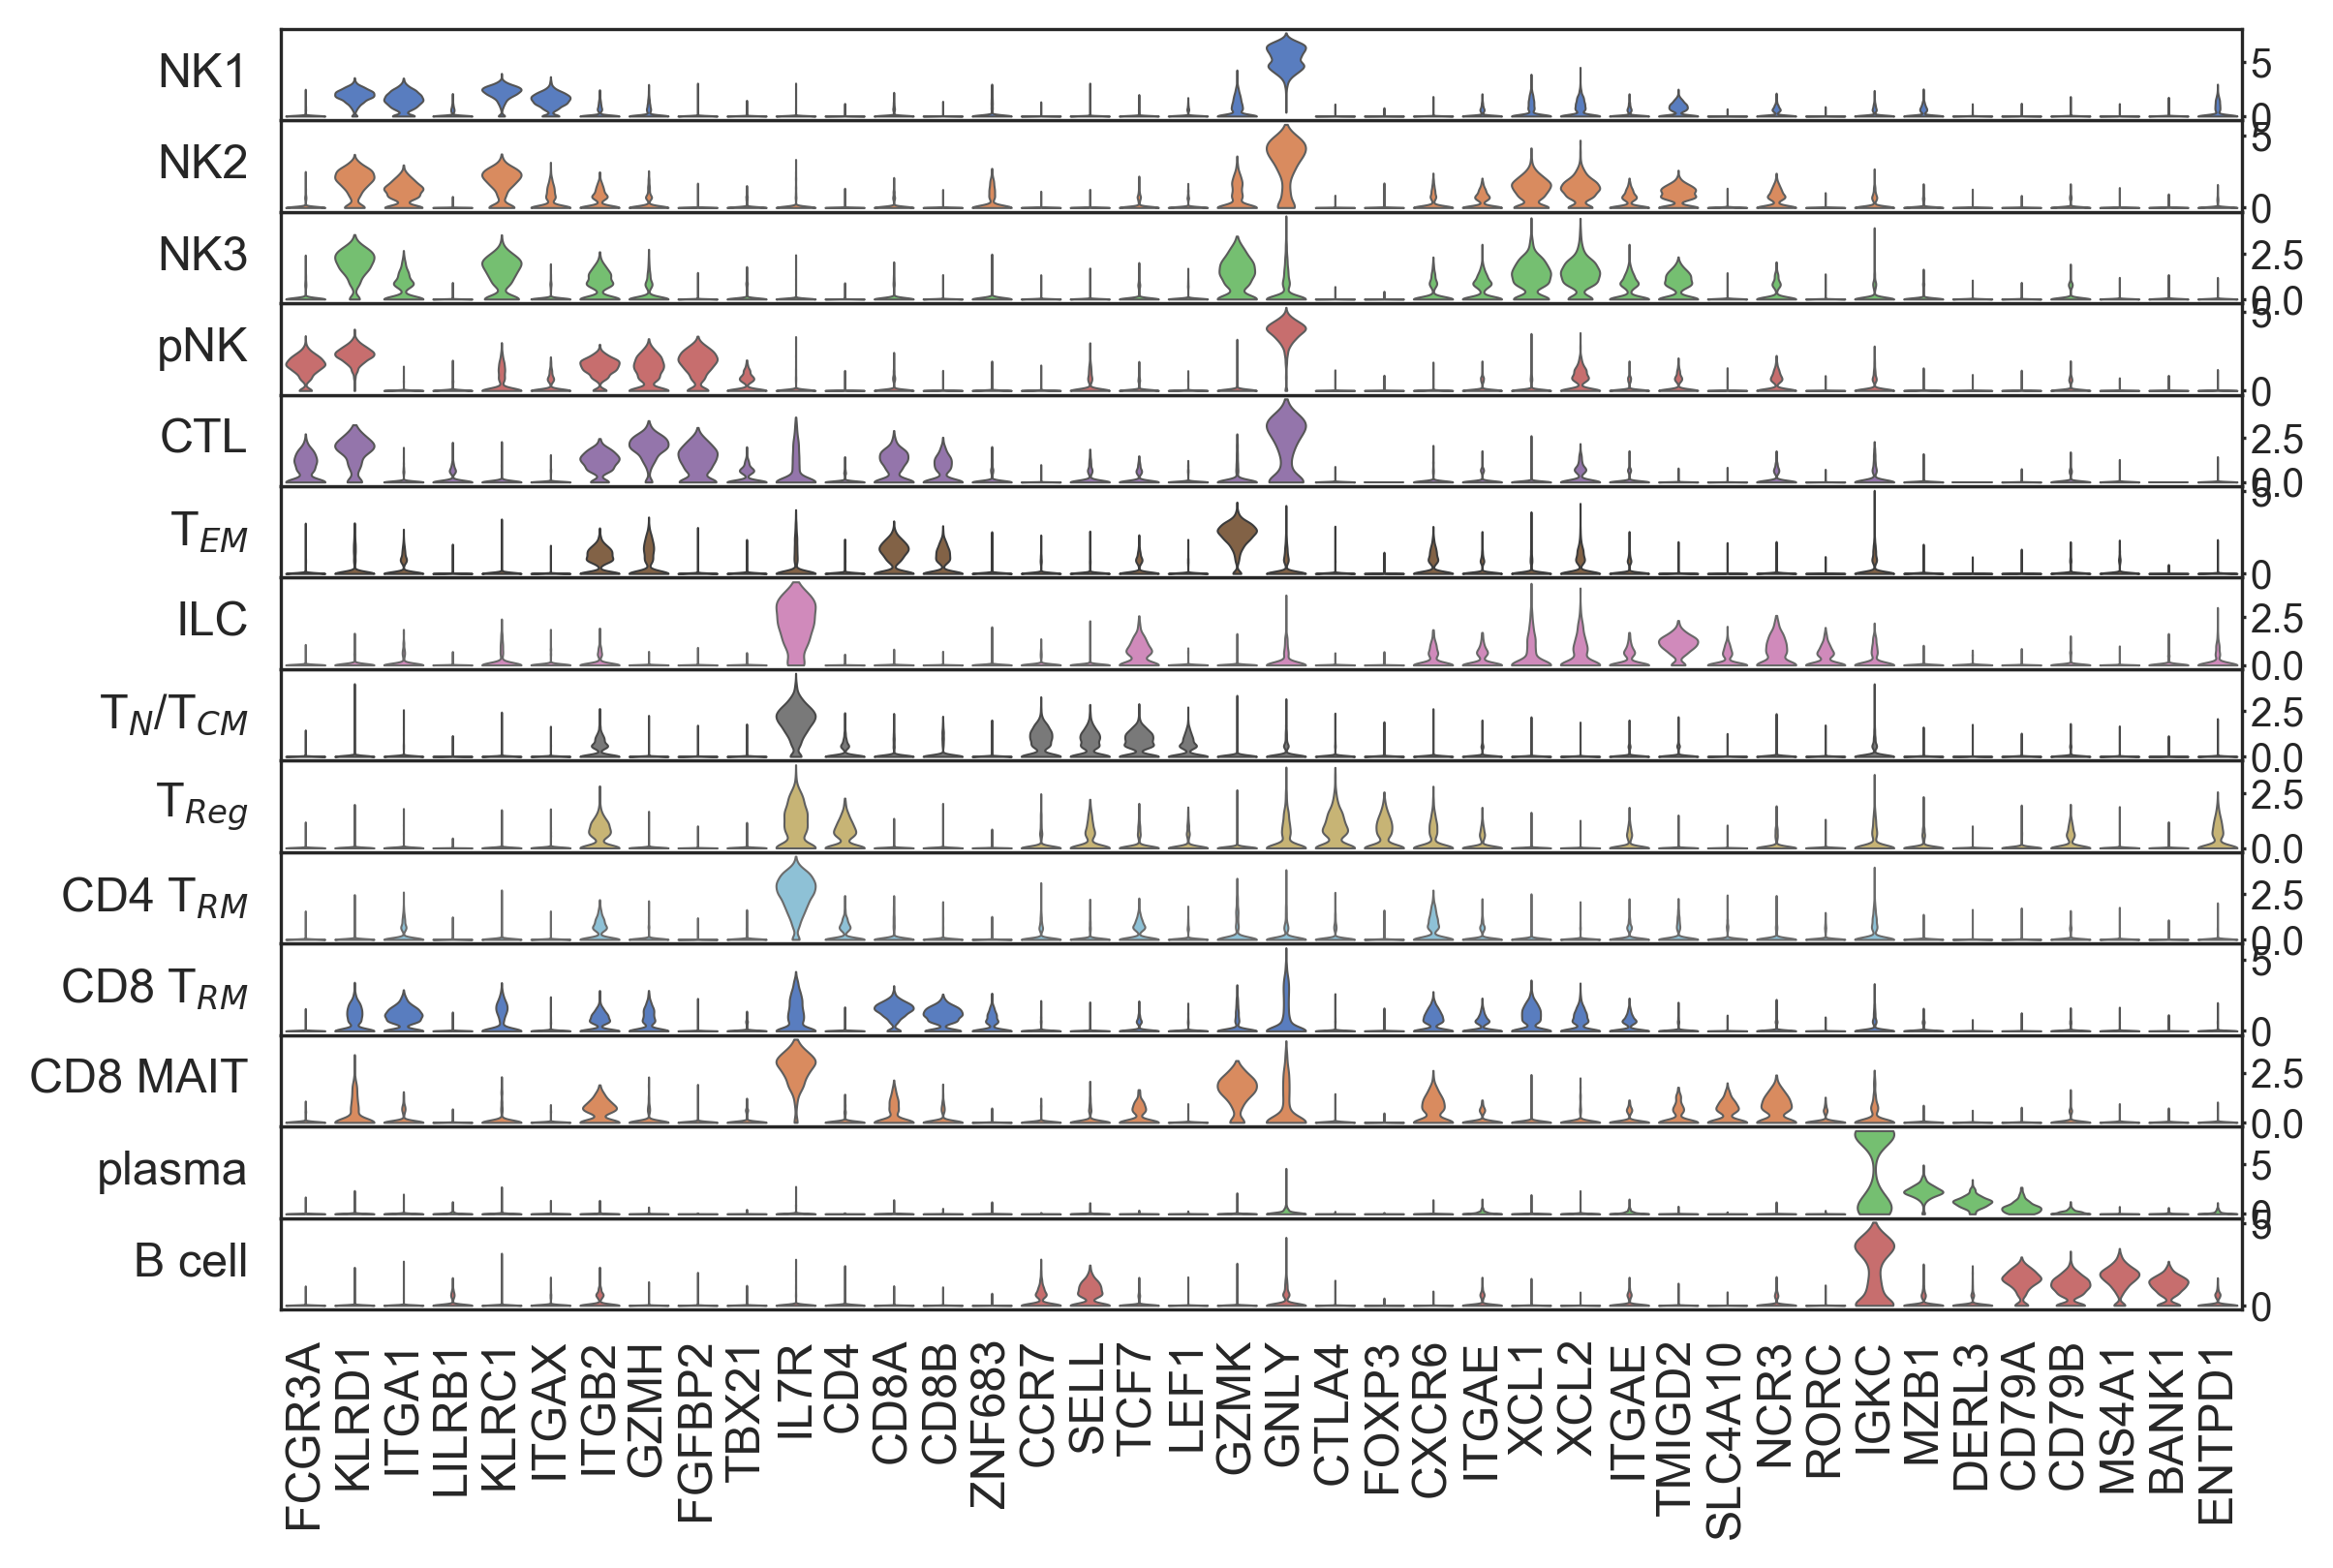

In [68]:
sc.pl.stacked_violin(clean,NK+Tcells+ILC+Bcells+["ENTPD1"],groupby="subtypes")

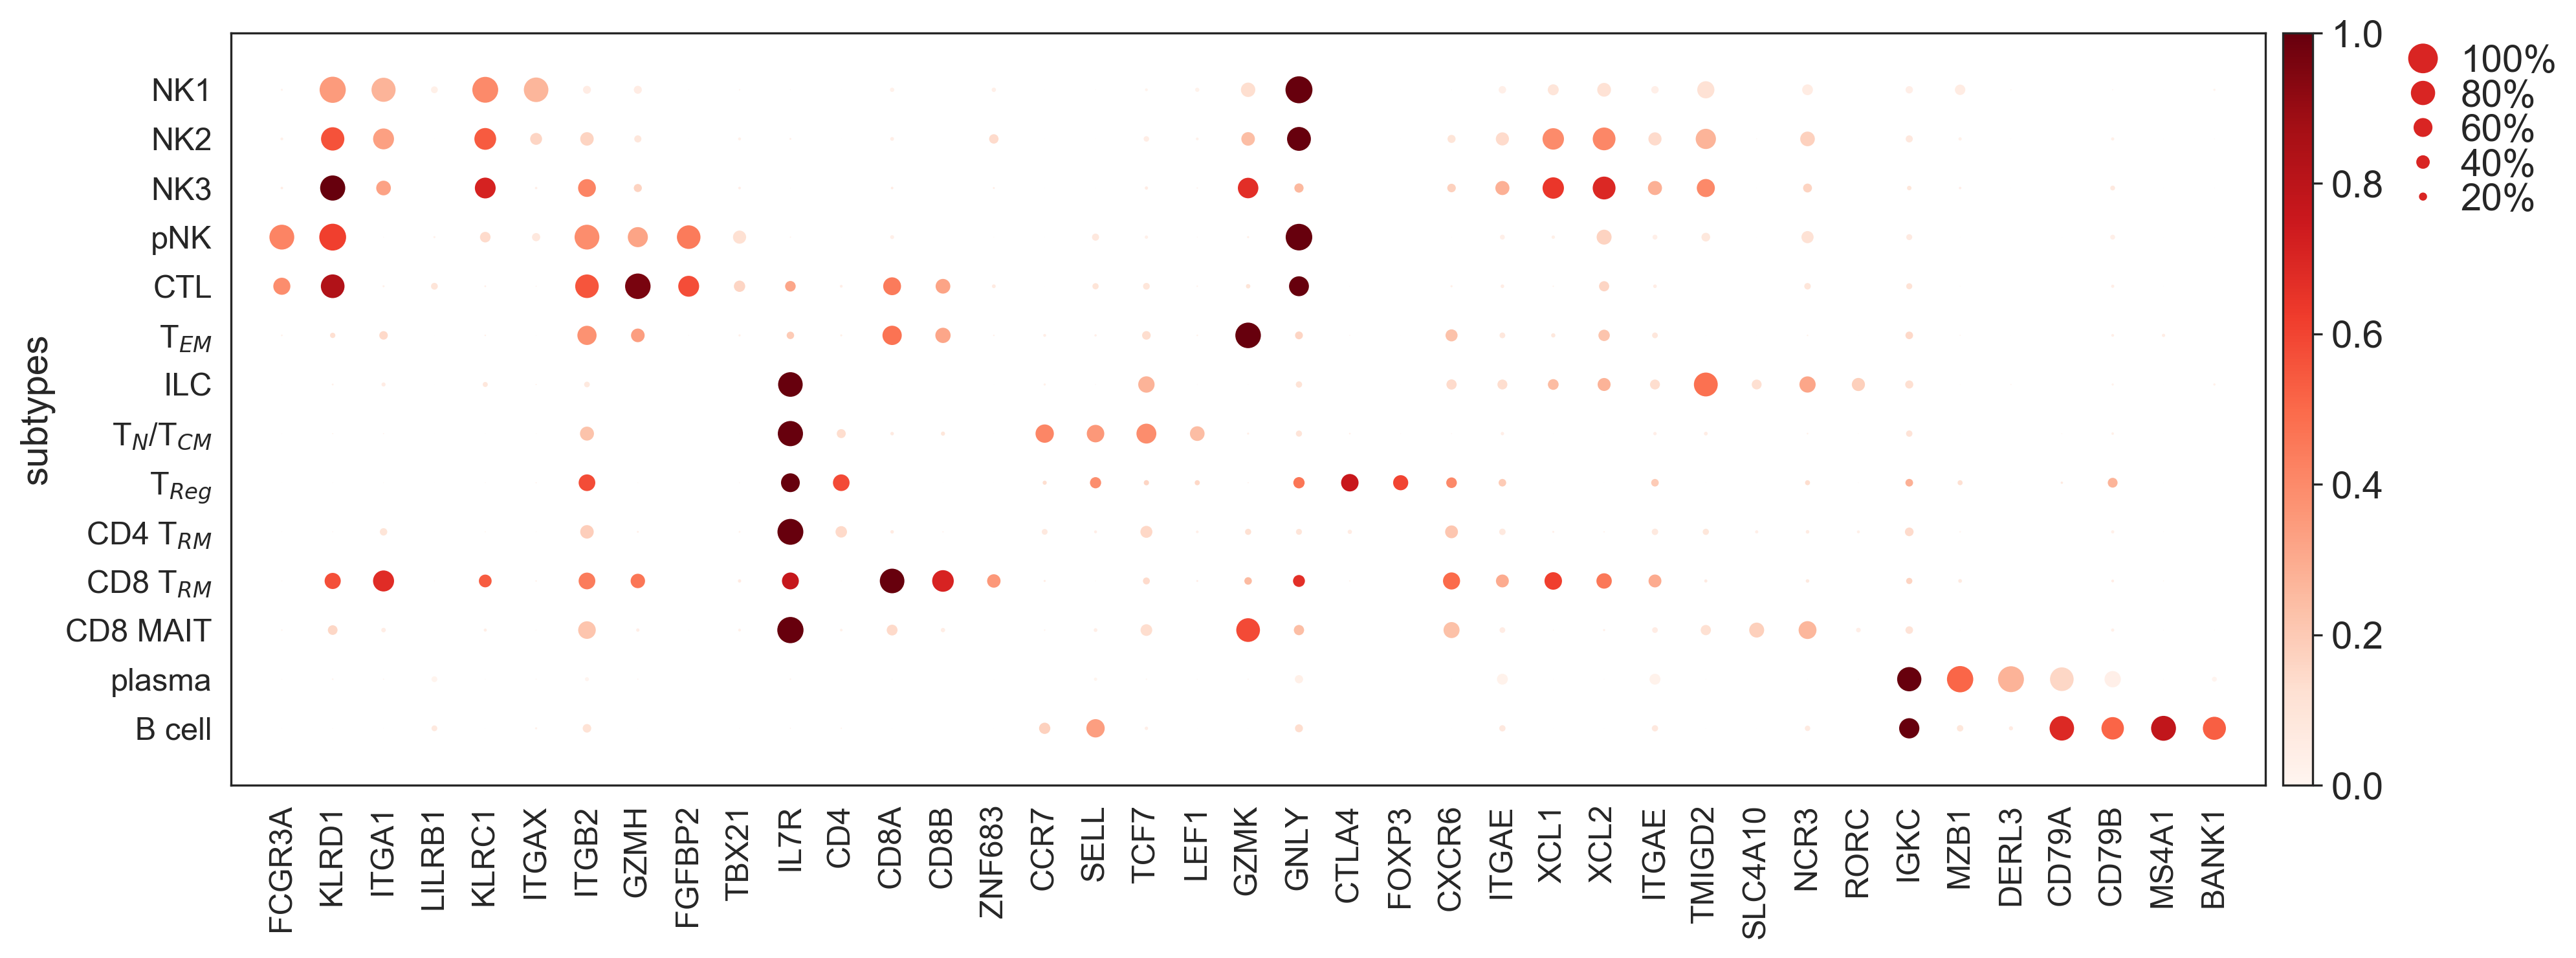

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[13.649999999999999, 0, 0.2, 0.5, 0.25])

In [69]:
sc.pl.dotplot(clean,NK+Tcells+ILC+Bcells,groupby="subtypes", standard_scale='group')

**markers of cell subtypes following the description on NK cells in [decidua](https://doi.org/10.1038/s41586-018-0698-6) and T cells from 15 major organs in an individual [He *et al.* (2020)](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02210-0)** 
<br> 2021-01-12

CD4 & CD8 markers based on [He *et al.* (2020)](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02210-0), **Single-cell transcriptome profiling of an adult human cell atlas of 15 major organs** 

---

#### Find Cluster Markers

In [161]:
compute_marker_genes(clean, groupby='lym_cluster',use_raw = False, suffix = "TNK",save=True)
compute_marker_genes(clean, groupby='subtypes',use_raw = False, suffix = "TNK-subtypes",save=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:26)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:39)


In [164]:
markers = compute_marker_genes(clean, groupby='subtypes',use_raw = False, suffix = "TNK",save=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:50)


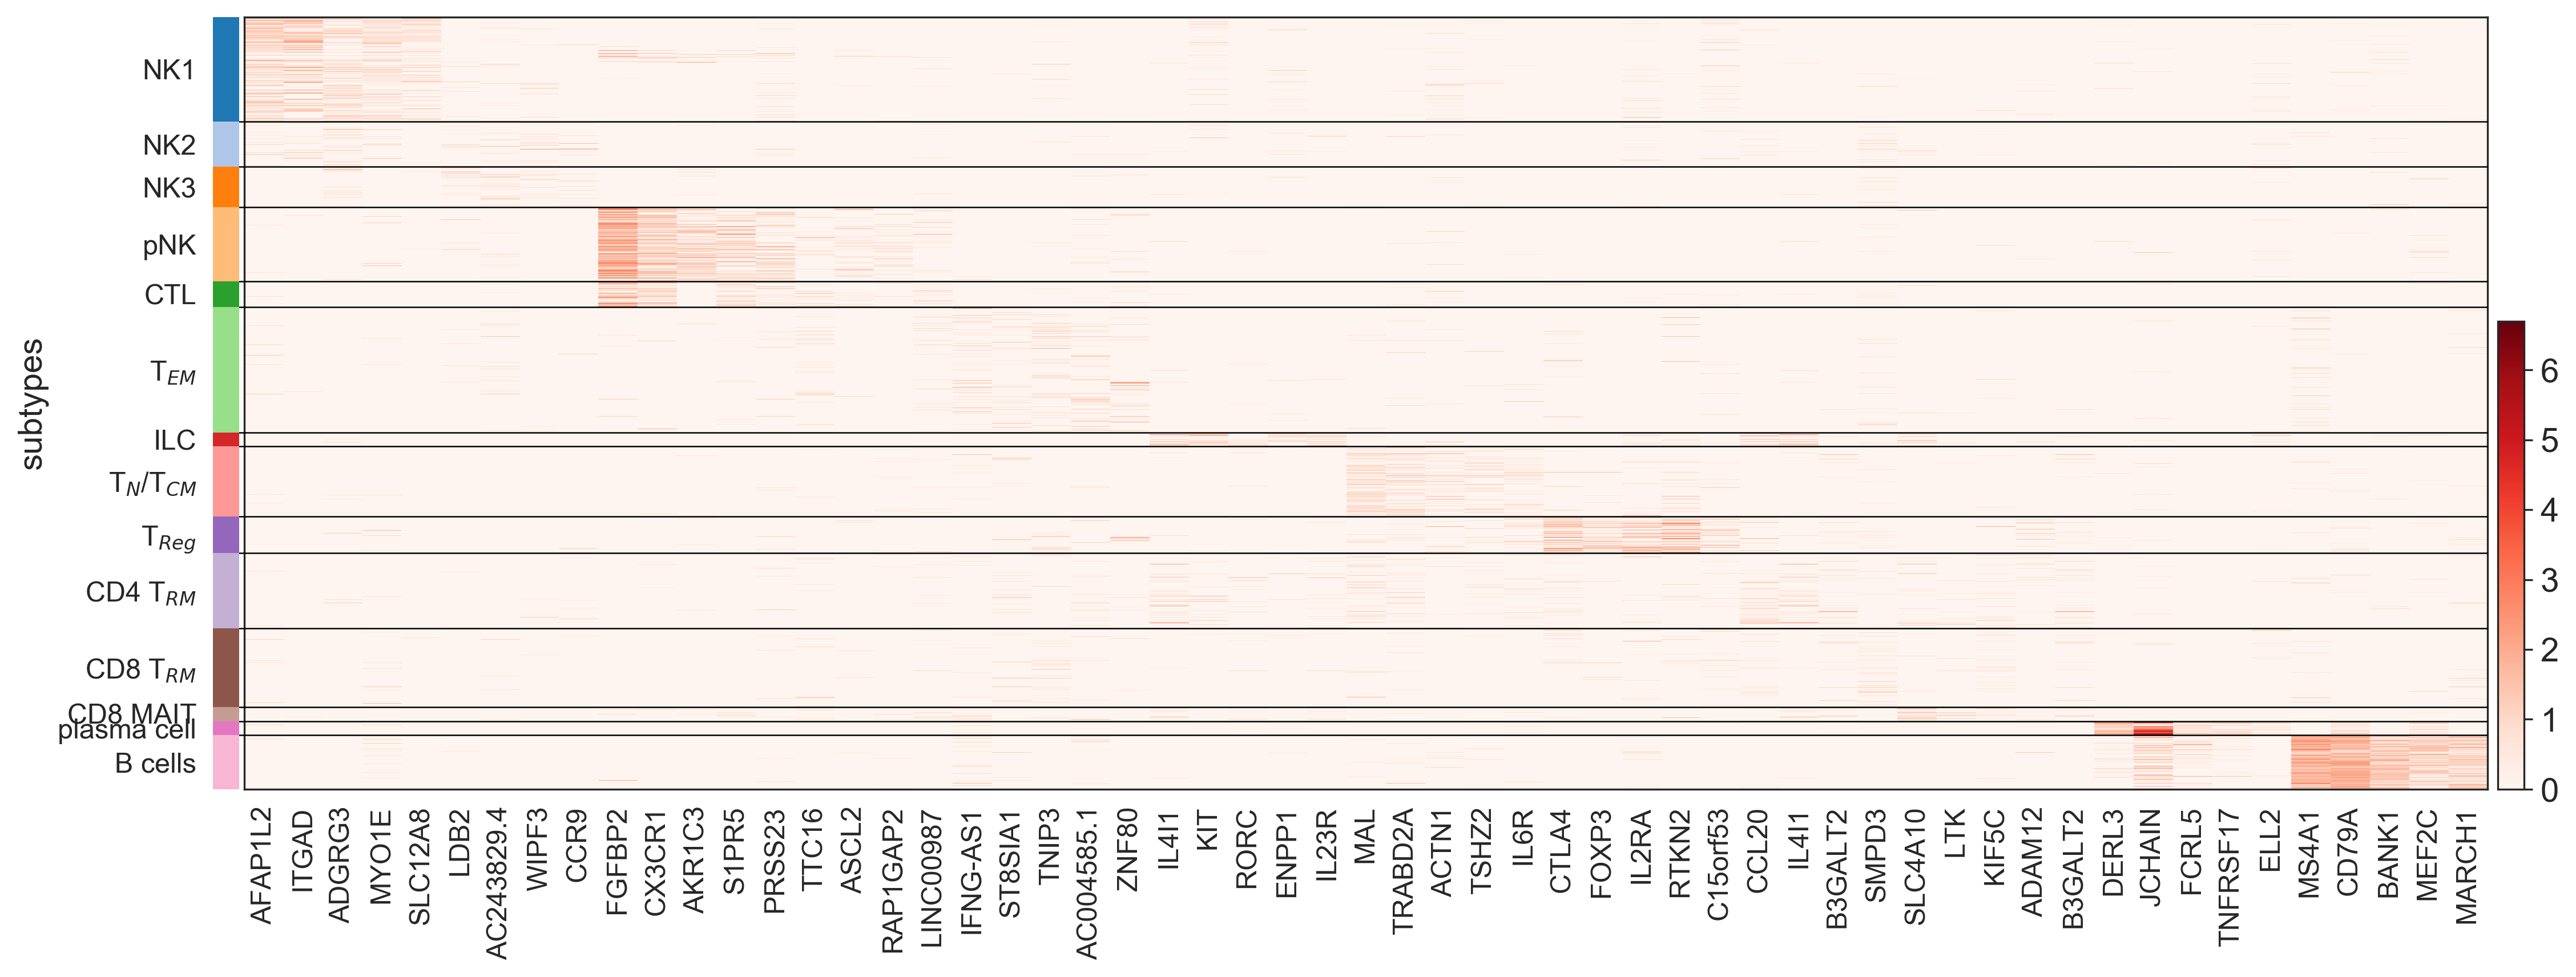

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 17.099999999999998, 0, 0.2])

In [165]:
sc.pl.heatmap(clean, var_names=markers.loc[markers["specific_5%"]==True].groupby('cluster').head(5).gene,
              use_raw=False,show_gene_labels=True, 
              groupby="subtypes",cmap='Reds')

---

#### Save for cLoupe

In [168]:
save_for_loupe(clean,"lym_cluster")

                    x coordinate  y coordinate
barcode                                       
AAACGCTAGCTCTGTA-1     12.525767      3.339887
AAACGCTGTACCTTCC-1      7.745725     12.801779
AAACGCTGTAGACACG-1      7.724679     12.775803
AAACGCTTCCATAGAC-1     12.713127      2.145286
AAACGCTTCCGATGTA-1      8.423814     12.118240
                   Custom Cluster            Celltype Patient ID Fragment ID  \
barcode                                                                        
AAACGCTAGCTCTGTA-1     Cluster 11  CD8+ T-lymphocytes         04     EC19001   
AAACGCTGTACCTTCC-1     Cluster 14            NK cells         04     EC19001   
AAACGCTGTAGACACG-1     Cluster 14            NK cells         04     EC19001   
AAACGCTTCCATAGAC-1     Cluster 11  CD8+ T-lymphocytes         04     EC19001   
AAACGCTTCCGATGTA-1     Cluster 14            NK cells         04     EC19001   

                   Sample Type      Subtypes  Old subtypes  
barcode                                          

---